XGBoost Regression - 'real-world' example: NYC Taxi-Fare Predictor

GP dEI versus STP nu = 3 dCBM (winner)

https://www.kaggle.com/c/new-york-city-taxi-fare-prediction

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"conorc2006","key":"c5c5a6382a7d50c022aab991694fc17f"}'}

In [2]:
## Ensure the kaggle.json file is present:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 66 Feb 24 12:56 kaggle.json


In [3]:
## Next, install the Kaggle API client:
!pip install -q kaggle

In [4]:
## The Kaggle API Client expects this file to be ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
## Permissions' change
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction

  0% 0.00/335k [00:00<?, ?B/s]
100% 335k/335k [00:00<00:00, 49.4MB/s]
100% 1.56G/1.56G [00:49<00:00, 26.9MB/s]
100% 1.56G/1.56G [00:49<00:00, 33.7MB/s]
  0% 0.00/960k [00:00<?, ?B/s]
100% 960k/960k [00:00<00:00, 61.8MB/s]
  0% 0.00/486 [00:00<?, ?B/s]
100% 486/486 [00:00<00:00, 1.71MB/s]


In [7]:
!pip install pyGPGO

In [8]:
# Load some default Python modules:

import numpy as np
import scipy as sp
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import xgboost as xgb
import time

from matplotlib.pyplot import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)
### % matplotlib inline
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from joblib import Parallel, delayed

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.surrogates.tStudentProcess import logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from pandas_datareader import data

import warnings
import random
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [9]:
# Read data in pandas dataframe:

df_train =  pd.read_csv('/content/train.csv.zip', nrows = 1_000_000, parse_dates=["pickup_datetime"])

In [10]:
# List first rows:

df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [11]:
# Format 'pickup_datetime' variable:

df_train['pickup_datetime'] =  pd.to_datetime(df_train['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
df_train['pickup_datetime'].head()

0   2009-06-15 17:26:21+00:00
1   2010-01-05 16:52:16+00:00
2   2011-08-18 00:35:00+00:00
3   2012-04-21 04:30:42+00:00
4   2010-03-09 07:51:00+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

In [12]:
df_train.sort_values(by = 'pickup_datetime').tail() ### June 2015 the final month

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
286276,2015-06-30 23:38:21.0000003,26.5,2015-06-30 23:38:21+00:00,-74.008385,40.711571,-73.884071,40.737385,5
955575,2015-06-30 23:45:57.0000003,4.0,2015-06-30 23:45:57+00:00,-74.002342,40.739819,-74.005829,40.745239,1
915826,2015-06-30 23:48:35.0000005,30.5,2015-06-30 23:48:35+00:00,-73.983826,40.729546,-73.927917,40.661186,2
751350,2015-06-30 23:53:23.0000002,3.5,2015-06-30 23:53:23+00:00,-73.978020,40.757439,-73.980705,40.753544,1
785182,2015-06-30 23:53:49.0000003,7.5,2015-06-30 23:53:49+00:00,-73.959969,40.762405,-73.953064,40.782688,1


In [13]:
# Add time variables:

df_train['hour'] = df_train['pickup_datetime'].dt.hour
df_train['weekday'] = df_train['pickup_datetime'].dt.weekday
df_train['month'] = df_train['pickup_datetime'].dt.month
df_train['year'] = df_train['pickup_datetime'].dt.year

In [14]:
df_train = df_train.drop(['pickup_datetime','key'], axis = 1)
df_train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,17,0,6,2009
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,16,1,1,2010
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0,3,8,2011
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,4,5,4,2012
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,7,1,3,2010


In [15]:
# Remove negative fares and postive outliers:

df_train = df_train[df_train.fare_amount>=0]
df_train = df_train[df_train.fare_amount<=60]
print('New size: %d' % len(df_train))

New size: 997297


In [16]:
# Remove missing data:

df_train = df_train.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(df_train))

New size: 997288


In [17]:
# June 2015 NYC taxi data (Wu et al, 2017):

df_train = df_train[df_train.month==6]
df_train = df_train[df_train.year==2015]
print('New size: %d' % len(df_train))

New size: 11269


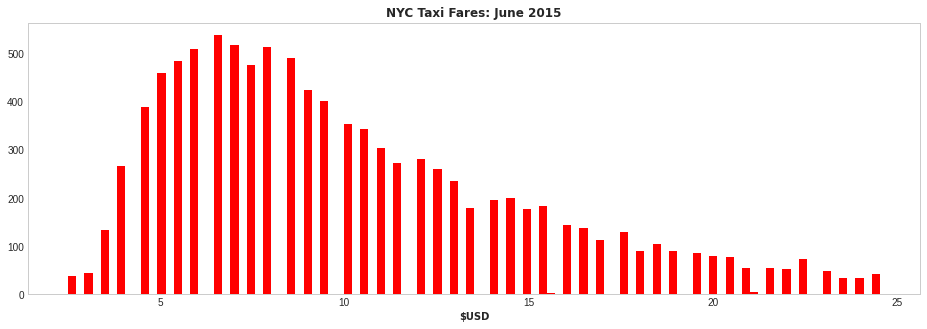

In [89]:
# Histogram fare plot:

df_train[df_train.fare_amount<25].fare_amount.hist(bins=100, figsize=(16,5), color = "red")
plt.xlabel('$USD', weight = 'bold', family = 'Arial')
plt.title('NYC Taxi Fares: June 2015', weight = 'bold', family = 'Arial')
plt.grid(b=None)

In [19]:
y = df_train.fare_amount.values + 1e-10
y ### for supervised learning: output vector y

array([22.54,  8.  , 34.  , ...,  4.5 ,  6.5 ,  7.  ])

In [20]:
# List first rows (post-cleaning):

df_train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year
31,22.54,-74.010483,40.717667,-73.985771,40.660366,1,21,6,6,2015
310,8.00,-74.010727,40.710091,-73.998100,40.722900,1,9,5,6,2015
314,34.00,-73.974899,40.751095,-73.908546,40.881878,0,23,1,6,2015
321,8.00,-73.961784,40.759579,-73.978943,40.772606,4,21,0,6,2015
486,11.50,-73.957443,40.761703,-73.973236,40.787079,1,19,0,6,2015


In [21]:
X = df_train.drop(['fare_amount', 'month', 'year'], axis = 1)
X.head() ### for supervised learning: input matrix X

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday
31,-74.010483,40.717667,-73.985771,40.660366,1,21,6
310,-74.010727,40.710091,-73.998100,40.722900,1,9,5
314,-73.974899,40.751095,-73.908546,40.881878,0,23,1
321,-73.961784,40.759579,-73.978943,40.772606,4,21,0
486,-73.957443,40.761703,-73.973236,40.787079,1,19,0


In [22]:
### Optimum rmse: regression model objective function is Root Mean Square Error (RMSE); 
### Should be minimized (as close to zero as possible):

y_global_orig = 0

In [23]:
obj_func = 'XGBoost'

In [24]:
### Objective function:

if obj_func == 'XGBoost': # 6-D
            
    # Constraints:
    param_lb_alpha = 0
    param_ub_alpha = 10
    
    param_lb_gamma = 0
    param_ub_gamma = 10
    
    param_lb_max_depth = 5
    param_ub_max_depth = 15
    
    param_lb_min_child_weight = 1
    param_ub_min_child_weight = 20
    
    param_lb_subsample = .5
    param_ub_subsample = 1
    
    param_lb_colsample = .1
    param_ub_colsample = 1
    
    # 6-D inputs' parameter bounds:
    param = { 'alpha':  ('cont', (param_lb_alpha, param_ub_alpha)),
         'gamma':  ('cont', (param_lb_gamma, param_ub_gamma)),     
         'max_depth':  ('int', (param_lb_max_depth, param_ub_max_depth)),
         'subsample':  ('cont', (param_lb_subsample, param_ub_subsample)),
          'min_child_weight':  ('int', (param_lb_min_child_weight, param_ub_min_child_weight)),
            'colsample': ('cont', (param_lb_colsample, param_ub_colsample))
        }
       
    # True y bounds:
    dim = 6
    
    max_iter = 20  # iterations of Bayesian optimization
    
    operator = 1 
    
    n_est = 3

In [25]:
### Bayesian Optimization - inputs:

n_start_AcqFunc = 100
n_test = n_start_AcqFunc # test points
df = 3 # nu

util_loser = 'dEI_GP'
util_winner = 'dCBM_STP'

v=1 
delta=.1
eval = 1 # starting point, increased by 1 using eval pyGPGO object for each iteration of Bayesian optimization
Beta_CBM = v * (2 * np.log((eval**(dim/2 + 2) * (np.pi**2))/(3 * delta)))

n_init = 5 # random initialisations

test_perc = 0.15
train_perc = 1 - test_perc

n_test = int(len(df_train) * test_perc)
n_train = int(len(df_train) - n_test)

In [26]:
### Derivatives - Squared-exponential covariance function:

def l2norm_(X, Xstar):
    
    return cdist(X, Xstar)

def kronDelta(X, Xstar):

    return cdist(X, Xstar) < np.finfo(np.float32).eps

class squaredExponentialDeriv(squaredExponential):
    
    def K(self, X, Xstar):
        
        r = (l2norm_(X, Xstar)/self.l)
        K = self.sigmaf * np.exp(-1/2*r **2) + self.sigman * kronDelta(X, Xstar)
        return K
    
    def dK(self, X, Xstar):
        
        r = (l2norm_(X, Xstar)/self.l)
        dK = self.sigmaf/self.l**2 * np.exp(-1/2 * r **2) * l2norm_(X, Xstar)
        return dK
    
        
    def d2K(self, X, Xstar):
        
        r = (l2norm_(X, Xstar)/self.l)
        d2K = self.sigmaf/self.l**2 * np.exp(-1/2 * r **2) * (1 - r **2)
        return d2K
    
cov_func = squaredExponentialDeriv()
d_cov_func = squaredExponentialDeriv()
    

In [27]:
### Set-seeds:

run_num_1 = 111
run_num_2 = 113
run_num_3 = 3333
run_num_4 = 4444
run_num_5 = 5555
run_num_6 = 6
run_num_7 = 7777
run_num_8 = 8878
run_num_9 = 999
run_num_10 = 1000
run_num_11 = 1113
run_num_12 = 1234
run_num_13 = 234
run_num_14 = 888
run_num_15 = 1557
run_num_16 = 1666
run_num_17 = 71
run_num_18 = 8
run_num_19 = 1999
run_num_20 = 2000

In [28]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list

In [29]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-08, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'dEI_GP': self.dEI_GP,
            'dCBM_STP': self.dCBM_STP
        }

        self.f = mode_dict[mode]
    
    def dEI_GP(self, tau, mean, std, ds, dm, dvdv, d2v, d2m):
        z = -1 * (tau - mean - self.eps) / (std + self.eps)
        
        dsdx = ds / 2 * (std + self.eps)
        d2sdx = -dsdx**2 / ((std + self.eps)) - dvdv / (std + self.eps) - d2v / (std + self.eps)
        dmdx = (dm - z * dsdx) / (std + self.eps)
        d2mdx = (d2m - (z * d2sdx + 2 * dmdx * dsdx)) / (std + self.eps)
        
        f = (std + self.eps) * (z * norm.cdf(z) + norm.pdf(z)[0])
        df = (f / (std + self.eps) * dsdx + (std + self.eps) * norm.cdf(z) * dmdx)
        d2f = (f / (std + self.eps) * d2sdx + dsdx * dmdx * norm.cdf(z) \
            + d2mdx * (std + self.eps) * norm.cdf(z) + dsdx * norm.cdf(z) * dmdx \
            + norm.pdf(z)[0] * (std + self.eps) * dmdx)
            
        return f, df, d2f

    def dCBM_STP(self, tau, mean, std, ds, dm, dvdv, d2v, d2m, nu=3.0):
    
        gamma = -1 * (y_global_orig - mean - self.eps) / (std + self.eps)
        dsdx = ds / 2 * (std + self.eps)
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * (dmdx + np.sqrt(Beta_CBM))
        return f, df
    
    def _eval(self, tau, mean, std):
    
        return self.f(tau, mean, std, **self.params)
    
    def d_eval(self, tau, mean, std, ds, dm, dvdv, d2v, d2m):
    
        return self.f(tau, mean, std, ds, dm, dvdv, d2v, d2m, **self.params)

    def d_eval_stp(self, tau, mean, std, ds, dm, dvdv, d2v, d2m, nu=3.0):
    
        return self.f(tau, mean, std, ds, dm, dvdv, d2v, d2m, nu=3.0, **self.params)


In [30]:
### Surrogate derivatives: 

from scipy.linalg import cholesky, solve

class dGaussianProcess(GaussianProcess):
    l = 1
    sigmaf = 1
    sigman = 1e-6

    def AcqGrad(self, Xstar, return_std=False):
        r_X = l2norm_(self.X, self.X)/self.l
        K = self.sigmaf * np.exp(-1/2*r_X **2) + self.sigman * kronDelta(self.X, self.X)
        L = cholesky(K).T
        alpha = solve(L.T, solve(L, self.y))
        Xstar = np.atleast_2d(Xstar)
        Kstar = squaredExponentialDeriv.K(self, self.X, Xstar).T
        dKstar = squaredExponentialDeriv.dK(self, self.X, Xstar).T
        d2Kstar = squaredExponentialDeriv.d2K(self, self.X, Xstar).T
        v = solve(self.L, Kstar.T)
        dv = solve(self.L, dKstar.T)
        d2v = solve(self.L, d2Kstar.T)
        
        ds = -2 * np.dot(dv.T, v)
        dvdv = np.dot(dv.T, dv)
        d2s = -2 * (dvdv + d2v)
        
        dm = np.dot(dKstar, alpha)
        d2m = np.dot(d2Kstar, alpha)
        return ds, dm, dvdv, d2v, d2m

class dtStudentProcess(tStudentProcess):
    l = 1
    sigmaf = 1
    sigman = 1e-6
    
    def AcqGrad(self, Xstar, return_std=False):
        r_X = l2norm_(self.X, self.X)/self.l
        K = self.sigmaf * np.exp(-1/2*r_X **2) + self.sigman * kronDelta(self.X, self.X)
        L = cholesky(self.K11).T
        alpha = solve(L.T, solve(L, self.y))
        Xstar = np.atleast_2d(Xstar)
        Kstar = squaredExponentialDeriv.K(self, self.X, Xstar).T
        dKstar = squaredExponentialDeriv.dK(self, self.X, Xstar).T
        d2Kstar = squaredExponentialDeriv.d2K(self, self.X, Xstar).T
        v = solve(L, Kstar.T)
        dv = solve(L, dKstar.T)
        d2v = solve(L, d2Kstar.T)
        
        ds = -2 * np.dot(dv.T, v)
        dvdv = np.dot(dv.T, dv)
        d2s = -2 * (dvdv + d2v)
        
        dm = np.dot(dKstar, alpha)
        d2m = np.dot(d2Kstar, alpha)
        return ds, dm, dvdv, d2v, d2m

In [31]:
class dGPGO(GPGO):  
    n_start = n_start_AcqFunc
    eps = 1e-08
        
    def func(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + 1e-6)
        ds, dm, dvdv, d2v, d2m = self.GP.AcqGrad(xnew, return_std=True)
        f  = np.empty((self.n_start,))
        df = np.empty((self.n_start,))
        f  = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m)[0]
        df = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m)[1]
        df_array = np.full((len(xnew),),df)
        return f, df_array
        
    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.func,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

In [32]:
## dGPGO_stp - BayesOpt derivatives' class: Student's-t

class dGPGO_stp(GPGO):  
    n_start = 100
        
    def func_stp(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + 1e-6)
        ds, dm, dvdv, d2v, d2m = self.GP.AcqGrad(xnew, return_std=True)
        f  = np.empty((self.n_start,))
        df = np.empty((self.n_start,))
        f  = -self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m, nu=df)[0]
        df = -self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2v=d2v, d2m=d2m, nu=df)[1]
        df_array = np.full((len(xnew),),df)
        return f, df_array
        
    def d_optimizeAcq_stp(self, method='L-BFGS-B', n_start=n_start):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.func_stp,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq_stp()
            self.updateGP()
            self.logger._printCurrent(self)

In [33]:
start_lose = time.time()
start_lose

1614171609.936492

In [34]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_loser_1 = dGaussianProcess(cov_func)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_perc, random_state=run_num_1)

def f_syn_polarity1(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_1, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train1, y=y_train1).mean())
    return operator * score

loser_1 = dGPGO(surrogate_loser_1, Acquisition_new(util_loser), f_syn_polarity1, param, n_jobs = -1) # define BayesOpt
loser_1.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_1 = loser_1.getResult()[0]
params_loser_1['max_depth'] = int(params_loser_1['max_depth'])
params_loser_1['min_child_weight'] = int(params_loser_1['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train1 = xgb.DMatrix(X_train1, y_train1)
dX_loser_test1 = xgb.DMatrix(X_test1, y_test1)
model_loser_1 = xgb.train(params_loser_1, dX_loser_train1)
pred_loser_1 = model_loser_1.predict(dX_loser_test1)

rmse_loser_1 = np.sqrt(mean_squared_error(pred_loser_1, y_test1))
rmse_loser_1

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.12170176  1.69069754 11.          0.92695323  3.          0.36579277]. 	  -0.5875926438135084 	 -0.45245711231879204
init   	 [ 1.49162957  0.22478325  6.          0.85613654 15.          0.19363322]. 	  -0.6811472770543097 	 -0.45245711231879204
init   	 [ 5.27957805  2.81819356 11.          0.81062146 14.          0.74826845]. 	  -0.46117277972616416 	 -0.45245711231879204
init   	 [3.81060005 6.24236569 7.         0.95038709 5.         0.9861745 ]. 	  -0.45245711231879204 	 -0.45245711231879204
init   	 [4.77531134 7.87990376 6.         0.78863691 6.         0.47918609]. 	  -0.5612893767574513 	 -0.45245711231879204
1      	 [0.  0.  5.  0.5 1.  0.1]. 	  -0.6826322236836013 	 -0.45245711231879204
2      	 [ 9.60774341  8.94642175  5.          0.60295867 15.          0.76784922]. 	  -0.5001571385184761 	 -0.45245711231879204
3      	 [ 0.4810761   9.31563532  8.          0.92845546 14.          0.70014982]. 	  -0.

4.87018129255363

In [35]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_loser_2 = dGaussianProcess(cov_func)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=test_perc, random_state=run_num_2)

def f_syn_polarity2(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_2, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train2, y=y_train2).mean())
    return operator * score

loser_2 = dGPGO(surrogate_loser_2, Acquisition_new(util_loser), f_syn_polarity2, param, n_jobs = -1) # define BayesOpt
loser_2.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_2 = loser_2.getResult()[0]
params_loser_2['max_depth'] = int(params_loser_2['max_depth'])
params_loser_2['min_child_weight'] = int(params_loser_2['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train2 = xgb.DMatrix(X_train2, y_train2)
dX_loser_test2 = xgb.DMatrix(X_test2, y_test2)
model_loser_2 = xgb.train(params_loser_2, dX_loser_train2)
pred_loser_2 = model_loser_2.predict(dX_loser_test2)

rmse_loser_2 = np.sqrt(mean_squared_error(pred_loser_2, y_test2))
rmse_loser_2

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.51985493  0.73903599  7.          0.71824677 17.          0.61827209]. 	  -0.5233872966482411 	 -0.42848969661986275
init   	 [ 8.4047092   4.35120551 12.          0.84231905 16.          0.80172484]. 	  -0.42848969661986275 	 -0.42848969661986275
init   	 [ 6.42749368  9.61026168 10.          0.73363448 15.          0.84932207]. 	  -0.43419399571353007 	 -0.42848969661986275
init   	 [ 2.66008363  8.36685389  6.          0.92082163 12.          0.69999264]. 	  -0.5353675801921922 	 -0.42848969661986275
init   	 [ 1.74779478  2.17691512 12.          0.71794562  2.          0.48990646]. 	  -0.5346620615324694 	 -0.42848969661986275
1      	 [0.65899411 0.08911785 5.         0.57513718 8.         0.6649358 ]. 	  -0.5435492302872315 	 -0.42848969661986275
2      	 [7.50154303 9.49874736 7.         0.83842364 4.         0.5714185 ]. 	  -0.5422231033003287 	 -0.42848969661986275
3      	 [9.88263606 1.71181353 7.        

4.343487868410211

In [36]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_loser_3 = dGaussianProcess(cov_func)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=test_perc, random_state=run_num_3)

def f_syn_polarity3(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_3, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train3, y=y_train3).mean())
    return operator * score

loser_3 = dGPGO(surrogate_loser_3, Acquisition_new(util_loser), f_syn_polarity3, param, n_jobs = -1) # define BayesOpt
loser_3.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_3 = loser_3.getResult()[0]
params_loser_3['max_depth'] = int(params_loser_3['max_depth'])
params_loser_3['min_child_weight'] = int(params_loser_3['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train3 = xgb.DMatrix(X_train3, y_train3)
dX_loser_test3 = xgb.DMatrix(X_test3, y_test3)
model_loser_3 = xgb.train(params_loser_3, dX_loser_train3)
pred_loser_3 = model_loser_3.predict(dX_loser_test3)

rmse_loser_3 = np.sqrt(mean_squared_error(pred_loser_3, y_test3))
rmse_loser_3

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.51575607  1.09251275 13.          0.80377147 16.          0.31229624]. 	  -0.6858957949546655 	 -0.5081673732303724
init   	 [6.12794891 1.19652403 5.         0.74822174 8.         0.33695838]. 	  -0.6849895205987827 	 -0.5081673732303724
init   	 [ 6.21631223  4.4909976  10.          0.66764529  9.          0.77207323]. 	  -0.5081673732303724 	 -0.5081673732303724
init   	 [ 0.58127233  4.79918477 11.          0.64526552 15.          0.62431773]. 	  -0.5106501747238601 	 -0.5081673732303724
init   	 [ 5.76228258  0.67219724  7.          0.88228691 13.          0.29867219]. 	  -0.6839256266327581 	 -0.5081673732303724
1      	 [9.79994489 9.57810833 8.         0.93763368 1.         0.1772549 ]. 	  -0.7316297465421655 	 -0.5081673732303724
2      	 [ 3.27075931  5.07207678 14.          0.99587284  2.          0.51564135]. 	  -0.6620507374994331 	 -0.5081673732303724
3      	 [0.         0.         5.         0.5     

4.6249009343932785

In [37]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_loser_4 = dGaussianProcess(cov_func)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=test_perc, random_state=run_num_4)

def f_syn_polarity4(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_4, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train4, y=y_train4).mean())
    return operator * score

loser_4 = dGPGO(surrogate_loser_4, Acquisition_new(util_loser), f_syn_polarity4, param, n_jobs = -1) # define BayesOpt
loser_4.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_4 = loser_4.getResult()[0]
params_loser_4['max_depth'] = int(params_loser_4['max_depth'])
params_loser_4['min_child_weight'] = int(params_loser_4['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train4 = xgb.DMatrix(X_train4, y_train4)
dX_loser_test4 = xgb.DMatrix(X_test4, y_test4)
model_loser_4 = xgb.train(params_loser_4, dX_loser_train4)
pred_loser_4 = model_loser_4.predict(dX_loser_test4)

rmse_loser_4 = np.sqrt(mean_squared_error(pred_loser_4, y_test4))
rmse_loser_4

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 9.42798506  1.23319667 14.          0.81910755  7.          0.7021549 ]. 	  -0.5581090891563811 	 -0.5581090891563811
init   	 [ 5.54158317  7.71233962 10.          0.59117644  6.          0.31476458]. 	  -0.6204181120564479 	 -0.5581090891563811
init   	 [2.18282634 2.93794127 7.         0.84739327 5.         0.62716229]. 	  -0.5626656925564042 	 -0.5581090891563811
init   	 [ 5.66159581  4.68678814 11.          0.54147808  9.          0.58609221]. 	  -0.5595885941852147 	 -0.5581090891563811
init   	 [ 3.02160958  6.07432614  6.          0.92038559 14.          0.12778609]. 	  -0.6361772582153176 	 -0.5581090891563811
1      	 [ 1.89460697  0.10324856 13.          0.70356349 16.          0.67776197]. 	  -0.5568243993303088 	 -0.5568243993303088
2      	 [ 9.69969     4.32607677 14.          0.87739158 16.          0.66014279]. 	  -0.5573098211239071 	 -0.5568243993303088
3      	 [ 2.2210328   8.31054196 13.        

4.469425637772456

In [38]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_loser_5 = dGaussianProcess(cov_func)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=test_perc, random_state=run_num_5)

def f_syn_polarity5(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_5, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train5, y=y_train5).mean())
    return operator * score

loser_5 = dGPGO(surrogate_loser_5, Acquisition_new(util_loser), f_syn_polarity5, param, n_jobs = -1) # define BayesOpt
loser_5.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_5 = loser_5.getResult()[0]
params_loser_5['max_depth'] = int(params_loser_5['max_depth'])
params_loser_5['min_child_weight'] = int(params_loser_5['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train5 = xgb.DMatrix(X_train5, y_train5)
dX_loser_test5 = xgb.DMatrix(X_test5, y_test5)
model_loser_5 = xgb.train(params_loser_5, dX_loser_train5)
pred_loser_5 = model_loser_5.predict(dX_loser_test5)

rmse_loser_5 = np.sqrt(mean_squared_error(pred_loser_5, y_test5))
rmse_loser_5

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.57353274  5.41760627  8.          0.53710825 19.          0.26034376]. 	  -0.6523797617249512 	 -0.466901759574539
init   	 [5.17826437 9.78817462 5.         0.84048437 6.         0.79712615]. 	  -0.4886603987288415 	 -0.466901759574539
init   	 [ 9.84476201  9.65484856  5.          0.59464714 19.          0.34528747]. 	  -0.564220001422124 	 -0.466901759574539
init   	 [ 9.17476842  4.53262239 13.          0.64368565 10.          0.515308  ]. 	  -0.5049042831858346 	 -0.466901759574539
init   	 [ 8.66719465  7.99685372 12.          0.79833571 17.          0.72443466]. 	  -0.466901759574539 	 -0.466901759574539
1      	 [ 3.31480734  6.81602635 12.          0.95330947  1.          0.27334927]. 	  -0.6531167190113543 	 -0.466901759574539
2      	 [2.53140694 0.29740057 9.         0.7505917  7.         0.82287404]. 	  -0.47475119282304395 	 -0.466901759574539
3      	 [ 9.84728748  0.28222034 13.          0.93969018  

4.31722690080873

In [39]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_loser_6 = dGaussianProcess(cov_func)

X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=test_perc, random_state=run_num_6)

def f_syn_polarity6(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_6, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train6, y=y_train6).mean())
    return operator * score

loser_6 = dGPGO(surrogate_loser_6, Acquisition_new(util_loser), f_syn_polarity6, param, n_jobs = -1) # define BayesOpt
loser_6.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_6 = loser_6.getResult()[0]
params_loser_6['max_depth'] = int(params_loser_6['max_depth'])
params_loser_6['min_child_weight'] = int(params_loser_6['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train6 = xgb.DMatrix(X_train6, y_train6)
dX_loser_test6 = xgb.DMatrix(X_test6, y_test6)
model_loser_6 = xgb.train(params_loser_6, dX_loser_train6)
pred_loser_6 = model_loser_6.predict(dX_loser_test6)

rmse_loser_6 = np.sqrt(mean_squared_error(pred_loser_6, y_test6))
rmse_loser_6

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [8.92860151 3.31979805 5.         0.99251441 2.         0.57683563]. 	  -0.5471181110640053 	 -0.5219867521874206
init   	 [4.18807429 3.35407849 9.         0.87750649 3.         0.56623277]. 	  -0.629286701398377 	 -0.5219867521874206
init   	 [ 5.788586    6.45355096 14.          0.70660047 12.          0.82154882]. 	  -0.5219867521874206 	 -0.5219867521874206
init   	 [4.58184578 6.73834679 5.         0.90108528 3.         0.65482895]. 	  -0.5476166257785141 	 -0.5219867521874206
init   	 [ 4.42510505  5.75952352 14.          0.97882365 15.          0.29525604]. 	  -0.6655867879161768 	 -0.5219867521874206
1      	 [ 7.09628606  0.82458553  6.          0.52978945 17.          0.78827589]. 	  -0.5368551114917748 	 -0.5219867521874206
2      	 [ 1.88885215  8.62524025  6.          0.90916563 14.          0.40379086]. 	  -0.6680072912825885 	 -0.5219867521874206
3      	 [ 0.5654966   9.52584762 14.          0.82016688 

4.1451215046465775

In [40]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_loser_7 = dGaussianProcess(cov_func)

X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=test_perc, random_state=run_num_7)

def f_syn_polarity7(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_7, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train7, y=y_train7).mean())
    return operator * score

loser_7 = dGPGO(surrogate_loser_7, Acquisition_new(util_loser), f_syn_polarity7, param, n_jobs = -1) # define BayesOpt
loser_7.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_7 = loser_7.getResult()[0]
params_loser_7['max_depth'] = int(params_loser_7['max_depth'])
params_loser_7['min_child_weight'] = int(params_loser_7['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train7 = xgb.DMatrix(X_train7, y_train7)
dX_loser_test7 = xgb.DMatrix(X_test7, y_test7)
model_loser_7 = xgb.train(params_loser_7, dX_loser_train7)
pred_loser_7 = model_loser_7.predict(dX_loser_test7)

rmse_loser_7 = np.sqrt(mean_squared_error(pred_loser_7, y_test7))
rmse_loser_7

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.11505126  6.92324143 13.          0.94046175 12.          0.3650384 ]. 	  -0.612852517751432 	 -0.4284992540085738
init   	 [ 5.15357029  9.0066636   6.          0.74104227 15.          0.8966337 ]. 	  -0.45500673865987984 	 -0.4284992540085738
init   	 [ 2.63548913  9.6610934  14.          0.64712408  1.          0.80820948]. 	  -0.43730487111474525 	 -0.4284992540085738
init   	 [ 1.40821426  1.72758589 12.          0.70495069  5.          0.86632715]. 	  -0.4284992540085738 	 -0.4284992540085738
init   	 [2.85126987 2.73434054 7.         0.88394733 8.         0.65545939]. 	  -0.48253390492139586 	 -0.4284992540085738
1      	 [1.03697999e-02 2.51695028e+00 1.40000000e+01 6.19497248e-01
 1.90000000e+01 7.01827417e-01]. 	  -0.47758423778274467 	 -0.4284992540085738
2      	 [9.9089961  7.50235155 7.         0.67925503 5.         0.2471192 ]. 	  -0.6736712023667494 	 -0.4284992540085738
3      	 [ 7.21196079  0.1138

4.492050628419268

In [41]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_loser_8 = dGaussianProcess(cov_func)

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=test_perc, random_state=run_num_8)

def f_syn_polarity8(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_8, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train8, y=y_train8).mean())
    return operator * score

loser_8 = dGPGO(surrogate_loser_8, Acquisition_new(util_loser), f_syn_polarity8, param, n_jobs = -1) # define BayesOpt
loser_8.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_8 = loser_8.getResult()[0]
params_loser_8['max_depth'] = int(params_loser_8['max_depth'])
params_loser_8['min_child_weight'] = int(params_loser_8['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train8 = xgb.DMatrix(X_train8, y_train8)
dX_loser_test8 = xgb.DMatrix(X_test8, y_test8)
model_loser_8 = xgb.train(params_loser_8, dX_loser_train8)
pred_loser_8 = model_loser_8.predict(dX_loser_test8)

rmse_loser_8 = np.sqrt(mean_squared_error(pred_loser_8, y_test8))
rmse_loser_8

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.29221489  0.77396898 11.          0.56062468  3.          0.25451879]. 	  -0.6231794271723858 	 -0.4674926150198253
init   	 [ 0.10611429  1.37648061  8.          0.6050375  15.          0.790205  ]. 	  -0.4674926150198253 	 -0.4674926150198253
init   	 [ 8.35239571  4.16908043  7.          0.67902746 14.          0.16683749]. 	  -0.6176439249709439 	 -0.4674926150198253
init   	 [ 6.06301777  7.27127491 12.          0.87295531 11.          0.37694382]. 	  -0.5951520828762356 	 -0.4674926150198253
init   	 [8.85209637 7.89269955 6.         0.72444854 3.         0.47766986]. 	  -0.5688519156580504 	 -0.4674926150198253
1      	 [ 1.47825581  9.16010046 11.          0.96606546  1.          0.92358292]. 	  -0.43518063190798095 	 -0.43518063190798095
2      	 [ 7.52273592  2.30141271 14.          0.75505047 19.          0.77804046]. 	  -0.45158957529537797 	 -0.43518063190798095
3      	 [1.64420908 9.47353882 5.       

4.711175290813375

In [42]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_loser_9 = dGaussianProcess(cov_func)

X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=test_perc, random_state=run_num_9)

def f_syn_polarity9(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_9, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train9, y=y_train9).mean())
    return operator * score

loser_9 = dGPGO(surrogate_loser_9, Acquisition_new(util_loser), f_syn_polarity9, param, n_jobs = -1) # define BayesOpt
loser_9.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_9 = loser_9.getResult()[0]
params_loser_9['max_depth'] = int(params_loser_9['max_depth'])
params_loser_9['min_child_weight'] = int(params_loser_9['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train9 = xgb.DMatrix(X_train9, y_train9)
dX_loser_test9 = xgb.DMatrix(X_test9, y_test9)
model_loser_9 = xgb.train(params_loser_9, dX_loser_train9)
pred_loser_9 = model_loser_9.predict(dX_loser_test9)

rmse_loser_9 = np.sqrt(mean_squared_error(pred_loser_9, y_test9))
rmse_loser_9

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.0342804   5.27522296 13.          0.60741904 17.          0.15336222]. 	  -0.6890593508433319 	 -0.4886355541929722
init   	 [7.56063644 1.79876369 7.         0.84869647 5.         0.55956942]. 	  -0.5532305414240943 	 -0.4886355541929722
init   	 [2.43675539 0.20225128 6.         0.51669963 7.         0.4646446 ]. 	  -0.5609155518755553 	 -0.4886355541929722
init   	 [ 7.6043547   4.73758376  9.          0.87564624 15.          0.65751286]. 	  -0.4886355541929722 	 -0.4886355541929722
init   	 [ 4.70349314  6.71029586  6.          0.97680389 11.          0.41971652]. 	  -0.6548660487332898 	 -0.4886355541929722
1      	 [ 0.20910387  7.25545521 14.          0.59407892  3.          0.95410586]. 	  -0.4312356520914486 	 -0.4312356520914486
2      	 [ 2.14892068  9.25577985 14.          0.84828472 11.          0.2793841 ]. 	  -0.6883959263608518 	 -0.4312356520914486
3      	 [ 0.37305557  1.02756836 13.          0.57

4.130636454660636

In [43]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_loser_10 = dGaussianProcess(cov_func)

X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=test_perc, random_state=run_num_10)

def f_syn_polarity10(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_10, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train10, y=y_train10).mean())
    return operator * score

loser_10 = dGPGO(surrogate_loser_10, Acquisition_new(util_loser), f_syn_polarity10, param, n_jobs = -1) # define BayesOpt
loser_10.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_10 = loser_10.getResult()[0]
params_loser_10['max_depth'] = int(params_loser_10['max_depth'])
params_loser_10['min_child_weight'] = int(params_loser_10['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train10 = xgb.DMatrix(X_train10, y_train10)
dX_loser_test10 = xgb.DMatrix(X_test10, y_test10)
model_loser_10 = xgb.train(params_loser_10, dX_loser_train10)
pred_loser_10 = model_loser_10.predict(dX_loser_test10)

rmse_loser_10 = np.sqrt(mean_squared_error(pred_loser_10, y_test10))
rmse_loser_10

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.53589585  1.15006943  6.          0.93623727 14.          0.13663866]. 	  -0.6929852048256443 	 -0.4483221221388197
init   	 [ 3.97194461  2.33132197 14.          0.9533253  19.          0.26403087]. 	  -0.6932702114662359 	 -0.4483221221388197
init   	 [ 7.43539415  0.69582081  9.          0.9763222  11.          0.12608349]. 	  -0.6931242497450955 	 -0.4483221221388197
init   	 [ 9.82027485  3.39637684  9.          0.78522537 19.          0.87618843]. 	  -0.4483221221388197 	 -0.4483221221388197
init   	 [ 0.57576207  5.82646405 12.          0.77704362 18.          0.11865044]. 	  -0.6946096327074635 	 -0.4483221221388197
1      	 [ 3.17878299  6.40666671 10.          0.71928645  2.          0.37920433]. 	  -0.6059745513602156 	 -0.4483221221388197
2      	 [ 3.37448201  8.10780464 13.          0.50477079 10.          0.914384  ]. 	  -0.43629727149692393 	 -0.43629727149692393
3      	 [ 9.185601    0.61355962 14.

4.436171669561738

In [44]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_loser_11 = dGaussianProcess(cov_func)

X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=test_perc, random_state=run_num_11)

def f_syn_polarity11(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train11, y=y_train11).mean())
    return operator * score

loser_11 = dGPGO(surrogate_loser_11, Acquisition_new(util_loser), f_syn_polarity11, param, n_jobs = -1) # define BayesOpt
loser_11.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_11 = loser_11.getResult()[0]
params_loser_11['max_depth'] = int(params_loser_11['max_depth'])
params_loser_11['min_child_weight'] = int(params_loser_11['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train11 = xgb.DMatrix(X_train11, y_train11)
dX_loser_test11 = xgb.DMatrix(X_test11, y_test11)
model_loser_11 = xgb.train(params_loser_11, dX_loser_train11)
pred_loser_11 = model_loser_11.predict(dX_loser_test11)

rmse_loser_11 = np.sqrt(mean_squared_error(pred_loser_11, y_test11))
rmse_loser_11

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 9.81035663  8.2124785   9.          0.68487173 15.          0.28207988]. 	  -0.7133787013189323 	 -0.47317045732943896
init   	 [ 4.91906771  1.38558332  6.          0.618878   19.          0.10263204]. 	  -0.7112023662943636 	 -0.47317045732943896
init   	 [ 5.23426175  1.89971159 13.          0.76313779 17.          0.46597853]. 	  -0.47317045732943896 	 -0.47317045732943896
init   	 [ 4.0204056   3.75167577  9.          0.86204818 17.          0.26560056]. 	  -0.7132057194891379 	 -0.47317045732943896
init   	 [8.8704459  5.64917815 5.         0.51406171 1.         0.82826731]. 	  -0.48048685248123163 	 -0.47317045732943896
1      	 [0.08349406 1.89250335 6.         0.66386636 1.         0.88641723]. 	  -0.4484239383130805 	 -0.4484239383130805
2      	 [ 5.35837408  0.31510164 14.          0.97519815  6.          0.3034681 ]. 	  -0.607905230502132 	 -0.4484239383130805
3      	 [ 4.66315557  9.30076713 11.        

4.3224670398414355

In [45]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_loser_12 = dGaussianProcess(cov_func)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X, y, test_size=test_perc, random_state=run_num_12)

def f_syn_polarity12(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_12, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train12, y=y_train12).mean())
    return operator * score

loser_12 = dGPGO(surrogate_loser_12, Acquisition_new(util_loser), f_syn_polarity12, param, n_jobs = -1) # define BayesOpt
loser_12.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_12 = loser_12.getResult()[0]
params_loser_12['max_depth'] = int(params_loser_12['max_depth'])
params_loser_12['min_child_weight'] = int(params_loser_12['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train12 = xgb.DMatrix(X_train12, y_train12)
dX_loser_test12 = xgb.DMatrix(X_test12, y_test12)
model_loser_12 = xgb.train(params_loser_12, dX_loser_train12)
pred_loser_12 = model_loser_12.predict(dX_loser_test12)

rmse_loser_12 = np.sqrt(mean_squared_error(pred_loser_12, y_test12))
rmse_loser_12

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.9151945   6.22108771  9.          0.89267929 16.          0.87460279]. 	  -0.4420077321695894 	 -0.4420077321695894
init   	 [ 1.50636966  1.98518759 11.          0.67890863 17.          0.5381501 ]. 	  -0.5998539491151165 	 -0.4420077321695894
init   	 [ 3.31015428  8.02639569  7.          0.75154158 13.          0.11992952]. 	  -0.7324503600335561 	 -0.4420077321695894
init   	 [ 2.90728553  2.46394443  5.          0.94461307 17.          0.43194161]. 	  -0.5995790338913064 	 -0.4420077321695894
init   	 [ 9.33140102  6.51378143  8.          0.76907392 18.          0.38515251]. 	  -0.5982523495604211 	 -0.4420077321695894
1      	 [5.68098653 8.6912739  6.         0.52027807 1.         0.51631894]. 	  -0.5999713561677879 	 -0.4420077321695894
2      	 [ 4.61089026  7.78540446 14.          0.61560224  6.          0.60910898]. 	  -0.5310432089168232 	 -0.4420077321695894
3      	 [ 7.71510638  1.71782806 11.        

3.9962203731848227

In [46]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_loser_13 = dGaussianProcess(cov_func)

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, test_size=test_perc, random_state=run_num_13)

def f_syn_polarity13(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_13, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train13, y=y_train13).mean())
    return operator * score

loser_13 = dGPGO(surrogate_loser_13, Acquisition_new(util_loser), f_syn_polarity13, param, n_jobs = -1) # define BayesOpt
loser_13.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_13 = loser_13.getResult()[0]
params_loser_13['max_depth'] = int(params_loser_13['max_depth'])
params_loser_13['min_child_weight'] = int(params_loser_13['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train13 = xgb.DMatrix(X_train13, y_train13)
dX_loser_test13 = xgb.DMatrix(X_test13, y_test13)
model_loser_13 = xgb.train(params_loser_13, dX_loser_train13)
pred_loser_13 = model_loser_13.predict(dX_loser_test13)

rmse_loser_13 = np.sqrt(mean_squared_error(pred_loser_13, y_test13))
rmse_loser_13

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.30967343  2.54282073  6.          0.9850871  17.          0.50848087]. 	  -0.5693403578256062 	 -0.4459810811310791
init   	 [ 6.95119021  3.25593423 14.          0.8602375   8.          0.82055713]. 	  -0.5112217679187058 	 -0.4459810811310791
init   	 [ 5.09252675  8.19921021 10.          0.78792002 16.          0.382158  ]. 	  -0.581693558072188 	 -0.4459810811310791
init   	 [ 5.4465191   3.19841462 14.          0.90654581  5.          0.10359415]. 	  -0.6818818523119694 	 -0.4459810811310791
init   	 [ 9.8393864   9.89619708  9.          0.63387763 10.          0.88979174]. 	  -0.4459810811310791 	 -0.4459810811310791
1      	 [ 9.27118046  9.4344906  10.          0.71578295  1.          0.5463837 ]. 	  -0.5604994598662556 	 -0.4459810811310791
2      	 [0.21910824 0.53051294 5.         0.62754372 4.         0.55299122]. 	  -0.578556985871312 	 -0.4459810811310791
3      	 [0.32904954 9.80442032 8.         0.72

4.159065314760995

In [47]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_loser_14 = dGaussianProcess(cov_func)

X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=test_perc, random_state=run_num_14)

def f_syn_polarity14(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_14, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train14, y=y_train14).mean())
    return operator * score

loser_14 = dGPGO(surrogate_loser_14, Acquisition_new(util_loser), f_syn_polarity14, param, n_jobs = -1) # define BayesOpt
loser_14.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_14 = loser_14.getResult()[0]
params_loser_14['max_depth'] = int(params_loser_14['max_depth'])
params_loser_14['min_child_weight'] = int(params_loser_14['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train14 = xgb.DMatrix(X_train14, y_train14)
dX_loser_test14 = xgb.DMatrix(X_test14, y_test14)
model_loser_14 = xgb.train(params_loser_14, dX_loser_train14)
pred_loser_14 = model_loser_14.predict(dX_loser_test14)

rmse_loser_14 = np.sqrt(mean_squared_error(pred_loser_14, y_test14))
rmse_loser_14

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.59560606  1.64569495 11.          0.89021195 15.          0.4857008 ]. 	  -0.6102441482204597 	 -0.4517949441804544
init   	 [ 0.57460093  9.25007434  5.          0.56647642 17.          0.7533211 ]. 	  -0.5614002279921607 	 -0.4517949441804544
init   	 [1.90674396 4.32019547 9.         0.93708225 3.         0.91775905]. 	  -0.4517949441804544 	 -0.4517949441804544
init   	 [ 0.36770475  8.43368681 14.          0.6826844  15.          0.6291966 ]. 	  -0.5407924410004543 	 -0.4517949441804544
init   	 [ 5.33840324  0.449182   14.          0.52045439  2.          0.48604556]. 	  -0.6242722768101235 	 -0.4517949441804544
1      	 [ 9.54492219  9.07631824  8.          0.54579372 12.          0.38295996]. 	  -0.6262431675183743 	 -0.4517949441804544
2      	 [9.53270461 0.83608685 6.         0.99976104 3.         0.60747265]. 	  -0.5533922160484371 	 -0.4517949441804544
3      	 [ 1.15250646  0.51569303  5.          0.69

4.334202643456426

In [48]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_loser_15 = dGaussianProcess(cov_func)

X_train15, X_test15, y_train15, y_test15 = train_test_split(X, y, test_size=test_perc, random_state=run_num_15)

def f_syn_polarity15(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_15, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train15, y=y_train15).mean())
    return operator * score

loser_15 = dGPGO(surrogate_loser_15, Acquisition_new(util_loser), f_syn_polarity15, param, n_jobs = -1) # define BayesOpt
loser_15.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_15 = loser_15.getResult()[0]
params_loser_15['max_depth'] = int(params_loser_15['max_depth'])
params_loser_15['min_child_weight'] = int(params_loser_15['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train15 = xgb.DMatrix(X_train15, y_train15)
dX_loser_test15 = xgb.DMatrix(X_test15, y_test15)
model_loser_15 = xgb.train(params_loser_15, dX_loser_train15)
pred_loser_15 = model_loser_15.predict(dX_loser_test15)

rmse_loser_15 = np.sqrt(mean_squared_error(pred_loser_15, y_test15))
rmse_loser_15

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.64315424  8.97297685  6.          0.81493635 11.          0.33008564]. 	  -0.5946480910132583 	 -0.4392277798535851
init   	 [9.51455383 9.60803032 5.         0.68485728 1.         0.30145081]. 	  -0.5968379804084254 	 -0.4392277798535851
init   	 [ 8.11809889  6.32508536  7.          0.61766329 19.          0.51383159]. 	  -0.5092318398204285 	 -0.4392277798535851
init   	 [ 7.28571251  5.36071389 10.          0.76240297 12.          0.12035683]. 	  -0.6346120183758519 	 -0.4392277798535851
init   	 [ 6.80847768  3.59767194 14.          0.51365585 16.          0.89730673]. 	  -0.4392277798535851 	 -0.4392277798535851
1      	 [ 2.28792065  8.58421878 12.          0.67551126  1.          0.37971264]. 	  -0.596161946051267 	 -0.4392277798535851
2      	 [ 9.35473751  1.48895841 12.          0.55362474  4.          0.11106606]. 	  -0.6327865627642436 	 -0.4392277798535851
3      	 [3.91572323 2.23174129 6.         0.5

4.189953800077167

In [49]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_loser_16 = dGaussianProcess(cov_func)

X_train16, X_test16, y_train16, y_test16 = train_test_split(X, y, test_size=test_perc, random_state=run_num_16)

def f_syn_polarity16(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_16, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train16, y=y_train16).mean())
    return operator * score

loser_16 = dGPGO(surrogate_loser_16, Acquisition_new(util_loser), f_syn_polarity16, param, n_jobs = -1) # define BayesOpt
loser_16.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_16 = loser_16.getResult()[0]
params_loser_16['max_depth'] = int(params_loser_16['max_depth'])
params_loser_16['min_child_weight'] = int(params_loser_16['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train16 = xgb.DMatrix(X_train16, y_train16)
dX_loser_test16 = xgb.DMatrix(X_test16, y_test16)
model_loser_16 = xgb.train(params_loser_16, dX_loser_train16)
pred_loser_16 = model_loser_16.predict(dX_loser_test16)

rmse_loser_16 = np.sqrt(mean_squared_error(pred_loser_16, y_test16))
rmse_loser_16

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [8.63948332 3.16366002 7.         0.75395583 1.         0.56999262]. 	  -0.5713220948397237 	 -0.4331621293825035
init   	 [ 3.3426621   9.77029134 14.          0.93751218 17.          0.80549151]. 	  -0.4331621293825035 	 -0.4331621293825035
init   	 [ 3.36871073  4.8308288  13.          0.91984982 14.          0.48829226]. 	  -0.5561611494046279 	 -0.4331621293825035
init   	 [ 8.84540736  1.59826081  8.          0.75772888 14.          0.29029227]. 	  -0.6835926126526815 	 -0.4331621293825035
init   	 [ 7.74981136  8.34377636 13.          0.83182409 15.          0.19378622]. 	  -0.7677243885128009 	 -0.4331621293825035
1      	 [ 0.60074712  1.1402995   5.          0.75926551 10.          0.30612858]. 	  -0.6844266759595645 	 -0.4331621293825035
2      	 [ 3.6191694   8.20490707  5.          0.81280746 16.          0.99306688]. 	  -0.4581574120389309 	 -0.4331621293825035
3      	 [ 0.55111138  3.69634376 11.        

4.361483761377183

In [50]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_loser_17 = dGaussianProcess(cov_func)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X, y, test_size=test_perc, random_state=run_num_17)

def f_syn_polarity17(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_17, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train17, y=y_train17).mean())
    return operator * score

loser_17 = dGPGO(surrogate_loser_17, Acquisition_new(util_loser), f_syn_polarity17, param, n_jobs = -1) # define BayesOpt
loser_17.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_17 = loser_17.getResult()[0]
params_loser_17['max_depth'] = int(params_loser_17['max_depth'])
params_loser_17['min_child_weight'] = int(params_loser_17['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train17 = xgb.DMatrix(X_train17, y_train17)
dX_loser_test17 = xgb.DMatrix(X_test17, y_test17)
model_loser_17 = xgb.train(params_loser_17, dX_loser_train17)
pred_loser_17 = model_loser_17.predict(dX_loser_test17)

rmse_loser_17 = np.sqrt(mean_squared_error(pred_loser_17, y_test17))
rmse_loser_17

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.85575275  3.86599303 13.          0.85645882  2.          0.78699813]. 	  -0.4597056260580034 	 -0.4597056260580034
init   	 [1.97780831 2.92527676 8.         0.92268607 9.         0.39017299]. 	  -0.5687207024308397 	 -0.4597056260580034
init   	 [ 7.16656007  1.028324    5.          0.96975483 15.          0.90932849]. 	  -0.4688025715067707 	 -0.4597056260580034
init   	 [ 2.46007304  9.53596657  7.          0.71704714 11.          0.17659118]. 	  -0.6983036523024195 	 -0.4597056260580034
init   	 [3.44161135 9.92427612 8.         0.96331165 2.         0.29160186]. 	  -0.5675253504862205 	 -0.4597056260580034
1      	 [ 9.98828606  3.49693094 13.          0.57156882  8.          0.14604355]. 	  -0.6992595730796743 	 -0.4597056260580034
2      	 [ 6.95619362  6.95953721 12.          0.92317057 19.          0.34981799]. 	  -0.5628121282495753 	 -0.4597056260580034
3      	 [8.58397417 0.63190934 7.         0.800496

4.347883948412589

In [51]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_loser_18 = dGaussianProcess(cov_func)

X_train18, X_test18, y_train18, y_test18 = train_test_split(X, y, test_size=test_perc, random_state=run_num_18)

def f_syn_polarity18(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train18, y=y_train18).mean())
    return operator * score

loser_18 = dGPGO(surrogate_loser_18, Acquisition_new(util_loser), f_syn_polarity18, param, n_jobs = -1) # define BayesOpt
loser_18.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_18 = loser_18.getResult()[0]
params_loser_18['max_depth'] = int(params_loser_18['max_depth'])
params_loser_18['min_child_weight'] = int(params_loser_18['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train18 = xgb.DMatrix(X_train18, y_train18)
dX_loser_test18 = xgb.DMatrix(X_test18, y_test18)
model_loser_18 = xgb.train(params_loser_18, dX_loser_train18)
pred_loser_18 = model_loser_18.predict(dX_loser_test18)

rmse_loser_18 = np.sqrt(mean_squared_error(pred_loser_18, y_test18))
rmse_loser_18

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.73429403  9.68540663 10.          0.68875849  9.          0.48011572]. 	  -0.48312028405718427 	 -0.4337207096533448
init   	 [ 6.12033333  7.66062926  8.          0.76133734 13.          0.93379456]. 	  -0.44701743563076113 	 -0.4337207096533448
init   	 [ 1.46524679  7.01527914  7.          0.90913299 10.          0.36016753]. 	  -0.6042122061654378 	 -0.4337207096533448
init   	 [ 9.73855241  3.33774046 14.          0.53290419  7.          0.7088681 ]. 	  -0.47205818581725156 	 -0.4337207096533448
init   	 [ 3.00618018  1.82702795 11.          0.75681389 14.          0.98627449]. 	  -0.4337207096533448 	 -0.4337207096533448
1      	 [ 1.46586883  1.13810325 14.          0.90052794  5.          0.16182112]. 	  -0.7143993241707929 	 -0.4337207096533448
2      	 [ 9.17850108  5.22481201 14.          0.60105853 18.          0.63442006]. 	  -0.47652759630987357 	 -0.4337207096533448
3      	 [6.20612396 4.37552923 6. 

3.937438334950126

In [52]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_loser_19 = dGaussianProcess(cov_func)

X_train19, X_test19, y_train19, y_test19 = train_test_split(X, y, test_size=test_perc, random_state=run_num_19)

def f_syn_polarity19(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_19, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train19, y=y_train19).mean())
    return operator * score

loser_19 = dGPGO(surrogate_loser_19, Acquisition_new(util_loser), f_syn_polarity19, param, n_jobs = -1) # define BayesOpt
loser_19.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_19 = loser_19.getResult()[0]
params_loser_19['max_depth'] = int(params_loser_19['max_depth'])
params_loser_19['min_child_weight'] = int(params_loser_19['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train19 = xgb.DMatrix(X_train19, y_train19)
dX_loser_test19 = xgb.DMatrix(X_test19, y_test19)
model_loser_19 = xgb.train(params_loser_19, dX_loser_train19)
pred_loser_19 = model_loser_19.predict(dX_loser_test19)

rmse_loser_19 = np.sqrt(mean_squared_error(pred_loser_19, y_test19))
rmse_loser_19

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.24520174  9.84626759 12.          0.81846905 12.          0.27594309]. 	  -0.6624515538441494 	 -0.4321567975765851
init   	 [ 8.6021676   8.64300514 14.          0.95067208 18.          0.13363564]. 	  -0.663790961968593 	 -0.4321567975765851
init   	 [ 3.02486657  6.06229509 10.          0.50494482  9.          0.10218675]. 	  -0.668875700942164 	 -0.4321567975765851
init   	 [ 6.57586195  8.01231848  7.          0.63945407 18.          0.49206406]. 	  -0.5640092362987262 	 -0.4321567975765851
init   	 [ 6.05008856  8.15558548 14.          0.64718943  8.          0.90611106]. 	  -0.4321567975765851 	 -0.4321567975765851
1      	 [ 0.85655458  0.69294498  9.          0.90992265 19.          0.25605959]. 	  -0.6632879756016564 	 -0.4321567975765851
2      	 [ 1.16239725  9.89254371 11.          0.98469188  1.          0.20271996]. 	  -0.6659068700895453 	 -0.4321567975765851
3      	 [9.26425961 9.717621   5.       

4.2307134915487135

In [53]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_loser_20 = dGaussianProcess(cov_func)

X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=test_perc, random_state=run_num_20)

def f_syn_polarity20(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_20, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train20, y=y_train20).mean())
    return operator * score

loser_20 = dGPGO(surrogate_loser_20, Acquisition_new(util_loser), f_syn_polarity20, param, n_jobs = -1) # define BayesOpt
loser_20.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_loser_20 = loser_20.getResult()[0]
params_loser_20['max_depth'] = int(params_loser_20['max_depth'])
params_loser_20['min_child_weight'] = int(params_loser_20['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_loser_train20 = xgb.DMatrix(X_train20, y_train20)
dX_loser_test20 = xgb.DMatrix(X_test20, y_test20)
model_loser_20 = xgb.train(params_loser_20, dX_loser_train20)
pred_loser_20 = model_loser_20.predict(dX_loser_test20)

rmse_loser_20 = np.sqrt(mean_squared_error(pred_loser_20, y_test20))
rmse_loser_20

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.70517285  5.64528755 11.          0.51213999 19.          0.57883228]. 	  -0.5510634045248362 	 -0.4667910180825121
init   	 [0.68106288 5.8452906  6.         0.58037829 8.         0.87974899]. 	  -0.4667910180825121 	 -0.4667910180825121
init   	 [ 4.04121426  7.17971417 11.          0.57603584 10.          0.19954225]. 	  -0.6541702754539586 	 -0.4667910180825121
init   	 [ 5.27556761  8.67655329 13.          0.54252273  4.          0.48570796]. 	  -0.5813476654605825 	 -0.4667910180825121
init   	 [ 5.30003889  5.73946822 12.          0.52666698 16.          0.77467019]. 	  -0.5078849923055367 	 -0.4667910180825121
1      	 [ 9.25190708  0.65043072 10.          0.56676233  5.          0.41289847]. 	  -0.6164858434894066 	 -0.4667910180825121
2      	 [8.65689736 8.11684598 5.         0.53907072 1.         0.87574215]. 	  -0.47576906935129115 	 -0.4667910180825121
3      	 [6.49728107e-01 7.72862043e-04 7.00000000

4.2900830531756915

In [54]:
end_lose = time.time()
end_lose

time_lose = end_lose - start_lose
time_lose

start_win = time.time()
start_win

1614173148.0209367

In [55]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_winner_1 = dtStudentProcess(d_cov_func, nu = df)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_perc, random_state=run_num_1)

def f_syn_polarity1(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_1, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train1, y=y_train1).mean())
    return operator * score

winner_1 = dGPGO_stp(surrogate_winner_1, Acquisition_new(util_winner), f_syn_polarity1, param, n_jobs = -1) # Define BayesOpt
winner_1.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_1 = winner_1.getResult()[0]
params_winner_1['max_depth'] = int(params_winner_1['max_depth'])
params_winner_1['min_child_weight'] = int(params_winner_1['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train1 = xgb.DMatrix(X_train1, y_train1)
dX_winner_test1 = xgb.DMatrix(X_test1, y_test1)
model_winner_1 = xgb.train(params_winner_1, dX_winner_train1)
pred_winner_1 = model_winner_1.predict(dX_winner_test1)

rmse_winner_1 = np.sqrt(mean_squared_error(pred_winner_1, y_test1))
rmse_winner_1

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.12170176  1.69069754 11.          0.92695323  3.          0.36579277]. 	  -0.5875926438135084 	 -0.45245711231879204
init   	 [ 1.49162957  0.22478325  6.          0.85613654 15.          0.19363322]. 	  -0.6811472770543097 	 -0.45245711231879204
init   	 [ 5.27957805  2.81819356 11.          0.81062146 14.          0.74826845]. 	  -0.46117277972616416 	 -0.45245711231879204
init   	 [3.81060005 6.24236569 7.         0.95038709 5.         0.9861745 ]. 	  -0.45245711231879204 	 -0.45245711231879204
init   	 [4.77531134 7.87990376 6.         0.78863691 6.         0.47918609]. 	  -0.5612893767574513 	 -0.45245711231879204
1      	 [ 8.28495996  8.75496601  5.          0.95020974 18.          0.2862647 ]. 	  -0.5992477418063687 	 -0.45245711231879204
2      	 [ 1.54653084  8.85277533 10.          0.53898233 18.          0.74883978]. 	  -0.4727718253663954 	 -0.45245711231879204
3      	 [ 0.39700633  8.08942284 14.     

4.457559893640606

In [56]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_winner_2 = dtStudentProcess(d_cov_func, nu = df)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=test_perc, random_state=run_num_2)

def f_syn_polarity2(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_2, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train2, y=y_train2).mean())
    return operator * score

winner_2 = dGPGO_stp(surrogate_winner_2, Acquisition_new(util_winner), f_syn_polarity2, param, n_jobs = -1) # Define BayesOpt
winner_2.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_2 = winner_2.getResult()[0]
params_winner_2['max_depth'] = int(params_winner_2['max_depth'])
params_winner_2['min_child_weight'] = int(params_winner_2['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train2 = xgb.DMatrix(X_train2, y_train2)
dX_winner_test2 = xgb.DMatrix(X_test2, y_test2)
model_winner_2 = xgb.train(params_winner_2, dX_winner_train2)
pred_winner_2 = model_winner_2.predict(dX_winner_test2)

rmse_winner_2 = np.sqrt(mean_squared_error(pred_winner_2, y_test2))
rmse_winner_2

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.51985493  0.73903599  7.          0.71824677 17.          0.61827209]. 	  -0.5233872966482411 	 -0.42848969661986275
init   	 [ 8.4047092   4.35120551 12.          0.84231905 16.          0.80172484]. 	  -0.42848969661986275 	 -0.42848969661986275
init   	 [ 6.42749368  9.61026168 10.          0.73363448 15.          0.84932207]. 	  -0.43419399571353007 	 -0.42848969661986275
init   	 [ 2.66008363  8.36685389  6.          0.92082163 12.          0.69999264]. 	  -0.5353675801921922 	 -0.42848969661986275
init   	 [ 1.74779478  2.17691512 12.          0.71794562  2.          0.48990646]. 	  -0.5346620615324694 	 -0.42848969661986275
1      	 [0.65899411 0.08911785 5.         0.57513718 8.         0.6649358 ]. 	  -0.5435492302872315 	 -0.42848969661986275
2      	 [7.50154303 9.49874736 7.         0.83842364 4.         0.5714185 ]. 	  -0.5422231033003287 	 -0.42848969661986275
3      	 [9.88263606 1.71181353 7.        

4.2995812032073975

In [57]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_winner_3 = dtStudentProcess(d_cov_func, nu = df)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=test_perc, random_state=run_num_3)

def f_syn_polarity3(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_3, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train3, y=y_train3).mean())
    return operator * score

winner_3 = dGPGO_stp(surrogate_winner_3, Acquisition_new(util_winner), f_syn_polarity3, param, n_jobs = -1) # Define BayesOpt
winner_3.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_3 = winner_3.getResult()[0]
params_winner_3['max_depth'] = int(params_winner_3['max_depth'])
params_winner_3['min_child_weight'] = int(params_winner_3['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train3 = xgb.DMatrix(X_train3, y_train3)
dX_winner_test3 = xgb.DMatrix(X_test3, y_test3)
model_winner_3 = xgb.train(params_winner_3, dX_winner_train3)
pred_winner_3 = model_winner_3.predict(dX_winner_test3)

rmse_winner_3 = np.sqrt(mean_squared_error(pred_winner_3, y_test3))
rmse_winner_3

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 7.51575607  1.09251275 13.          0.80377147 16.          0.31229624]. 	  -0.6858957949546655 	 -0.5081673732303724
init   	 [6.12794891 1.19652403 5.         0.74822174 8.         0.33695838]. 	  -0.6849895205987827 	 -0.5081673732303724
init   	 [ 6.21631223  4.4909976  10.          0.66764529  9.          0.77207323]. 	  -0.5081673732303724 	 -0.5081673732303724
init   	 [ 0.58127233  4.79918477 11.          0.64526552 15.          0.62431773]. 	  -0.5106501747238601 	 -0.5081673732303724
init   	 [ 5.76228258  0.67219724  7.          0.88228691 13.          0.29867219]. 	  -0.6839256266327581 	 -0.5081673732303724
1      	 [9.79994489 9.57810833 8.         0.93763368 1.         0.1772549 ]. 	  -0.7316297465421655 	 -0.5081673732303724
2      	 [0.57418139 4.52928726 5.         0.80084727 1.         0.7169273 ]. 	  -0.5216224915283247 	 -0.5081673732303724
3      	 [ 9.58141527  7.64408898  6.          0.86433791

4.549660942552857

In [58]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_winner_4 = dtStudentProcess(d_cov_func, nu = df)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=test_perc, random_state=run_num_4)

def f_syn_polarity4(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_4, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train4, y=y_train4).mean())
    return operator * score

winner_4 = dGPGO_stp(surrogate_winner_4, Acquisition_new(util_winner), f_syn_polarity4, param, n_jobs = -1) # Define BayesOpt
winner_4.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_4 = winner_4.getResult()[0]
params_winner_4['max_depth'] = int(params_winner_4['max_depth'])
params_winner_4['min_child_weight'] = int(params_winner_4['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train4 = xgb.DMatrix(X_train4, y_train4)
dX_winner_test4 = xgb.DMatrix(X_test4, y_test4)
model_winner_4 = xgb.train(params_winner_4, dX_winner_train4)
pred_winner_4 = model_winner_4.predict(dX_winner_test4)

rmse_winner_4 = np.sqrt(mean_squared_error(pred_winner_4, y_test4))
rmse_winner_4

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 9.42798506  1.23319667 14.          0.81910755  7.          0.7021549 ]. 	  -0.5581090891563811 	 -0.5581090891563811
init   	 [ 5.54158317  7.71233962 10.          0.59117644  6.          0.31476458]. 	  -0.6204181120564479 	 -0.5581090891563811
init   	 [2.18282634 2.93794127 7.         0.84739327 5.         0.62716229]. 	  -0.5626656925564042 	 -0.5581090891563811
init   	 [ 5.66159581  4.68678814 11.          0.54147808  9.          0.58609221]. 	  -0.5595885941852147 	 -0.5581090891563811
init   	 [ 3.02160958  6.07432614  6.          0.92038559 14.          0.12778609]. 	  -0.6361772582153176 	 -0.5581090891563811
1      	 [ 1.89460697  0.10324856 13.          0.70356349 16.          0.67776197]. 	  -0.5568243993303088 	 -0.5568243993303088
2      	 [ 9.69969     4.32607677 14.          0.87739158 16.          0.66014279]. 	  -0.5573098211239071 	 -0.5568243993303088
3      	 [ 2.2210328   8.31054196 13.        

4.434296926742622

In [59]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_winner_5 = dtStudentProcess(d_cov_func, nu = df)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=test_perc, random_state=run_num_5)

def f_syn_polarity5(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_5, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train5, y=y_train5).mean())
    return operator * score

winner_5 = dGPGO_stp(surrogate_winner_5, Acquisition_new(util_winner), f_syn_polarity5, param, n_jobs = -1) # Define BayesOpt
winner_5.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_5 = winner_5.getResult()[0]
params_winner_5['max_depth'] = int(params_winner_5['max_depth'])
params_winner_5['min_child_weight'] = int(params_winner_5['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train5 = xgb.DMatrix(X_train5, y_train5)
dX_winner_test5 = xgb.DMatrix(X_test5, y_test5)
model_winner_5 = xgb.train(params_winner_5, dX_winner_train5)
pred_winner_5 = model_winner_5.predict(dX_winner_test5)

rmse_winner_5 = np.sqrt(mean_squared_error(pred_winner_5, y_test5))
rmse_winner_5

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.57353274  5.41760627  8.          0.53710825 19.          0.26034376]. 	  -0.6523797617249512 	 -0.466901759574539
init   	 [5.17826437 9.78817462 5.         0.84048437 6.         0.79712615]. 	  -0.4886603987288415 	 -0.466901759574539
init   	 [ 9.84476201  9.65484856  5.          0.59464714 19.          0.34528747]. 	  -0.564220001422124 	 -0.466901759574539
init   	 [ 9.17476842  4.53262239 13.          0.64368565 10.          0.515308  ]. 	  -0.5049042831858346 	 -0.466901759574539
init   	 [ 8.66719465  7.99685372 12.          0.79833571 17.          0.72443466]. 	  -0.466901759574539 	 -0.466901759574539
1      	 [ 3.31480734  6.81602635 12.          0.95330947  1.          0.27334927]. 	  -0.6531167190113543 	 -0.466901759574539
2      	 [2.53140694 0.29740057 9.         0.7505917  7.         0.82287404]. 	  -0.47475119282304395 	 -0.466901759574539
3      	 [ 9.84728748  0.28222034 13.          0.93969018  

4.213961785908059

In [60]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_winner_6 = dtStudentProcess(d_cov_func, nu = df)

X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=test_perc, random_state=run_num_6)

def f_syn_polarity6(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=int(min_child_weight),
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_6, objective = 'reg:squarederror', eval_metric = 'rmse')
    score = np.array(cross_val_score(reg, X=X_train6, y=y_train6).mean())
    return operator * score

winner_6 = dGPGO_stp(surrogate_winner_6, Acquisition_new(util_winner), f_syn_polarity6, param, n_jobs = -1) # Define BayesOpt
winner_6.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_6 = winner_6.getResult()[0]
params_winner_6['max_depth'] = int(params_winner_6['max_depth'])
params_winner_6['min_child_weight'] = int(params_winner_6['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train6 = xgb.DMatrix(X_train6, y_train6)
dX_winner_test6 = xgb.DMatrix(X_test6, y_test6)
model_winner_6 = xgb.train(params_winner_6, dX_winner_train6)
pred_winner_6 = model_winner_6.predict(dX_winner_test6)

rmse_winner_6 = np.sqrt(mean_squared_error(pred_winner_6, y_test6))
rmse_winner_6

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [8.92860151 3.31979805 5.         0.99251441 2.         0.57683563]. 	  -0.5471181110640053 	 -0.5219867521874206
init   	 [4.18807429 3.35407849 9.         0.87750649 3.         0.56623277]. 	  -0.629286701398377 	 -0.5219867521874206
init   	 [ 5.788586    6.45355096 14.          0.70660047 12.          0.82154882]. 	  -0.5219867521874206 	 -0.5219867521874206
init   	 [4.58184578 6.73834679 5.         0.90108528 3.         0.65482895]. 	  -0.5476166257785141 	 -0.5219867521874206
init   	 [ 4.42510505  5.75952352 14.          0.97882365 15.          0.29525604]. 	  -0.6655867879161768 	 -0.5219867521874206
1      	 [ 7.09628606  0.82458553  6.          0.52978945 17.          0.78827589]. 	  -0.5368551114917748 	 -0.5219867521874206
2      	 [ 9.72322443  9.21177696  5.          0.87917074 11.          0.86681736]. 	  -0.4531024667502284 	 -0.4531024667502284
3      	 [ 0.5654966   9.52584762 14.          0.82016688 

4.137125352816465

In [61]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_winner_7 = dtStudentProcess(d_cov_func, nu = df)

X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=test_perc, random_state=run_num_7)

def f_syn_polarity7(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_7, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train7, y=y_train7).mean())
    return operator * score

winner_7 = dGPGO_stp(surrogate_winner_7, Acquisition_new(util_winner), f_syn_polarity7, param, n_jobs = -1) # Define BayesOpt
winner_7.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_7 = winner_7.getResult()[0]
params_winner_7['max_depth'] = int(params_winner_7['max_depth'])
params_winner_7['min_child_weight'] = int(params_winner_7['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train7 = xgb.DMatrix(X_train7, y_train7)
dX_winner_test7 = xgb.DMatrix(X_test7, y_test7)
model_winner_7 = xgb.train(params_winner_7, dX_winner_train7)
pred_winner_7 = model_winner_7.predict(dX_winner_test7)

rmse_winner_7 = np.sqrt(mean_squared_error(pred_winner_7, y_test7))
rmse_winner_7

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.11505126  6.92324143 13.          0.94046175 12.          0.3650384 ]. 	  -0.612852517751432 	 -0.4284992540085738
init   	 [ 5.15357029  9.0066636   6.          0.74104227 15.          0.8966337 ]. 	  -0.45500673865987984 	 -0.4284992540085738
init   	 [ 2.63548913  9.6610934  14.          0.64712408  1.          0.80820948]. 	  -0.43730487111474525 	 -0.4284992540085738
init   	 [ 1.40821426  1.72758589 12.          0.70495069  5.          0.86632715]. 	  -0.4284992540085738 	 -0.4284992540085738
init   	 [2.85126987 2.73434054 7.         0.88394733 8.         0.65545939]. 	  -0.48253390492139586 	 -0.4284992540085738
1      	 [1.03697999e-02 2.51695028e+00 1.40000000e+01 6.19497248e-01
 1.90000000e+01 7.01827417e-01]. 	  -0.47758423778274467 	 -0.4284992540085738
2      	 [9.9089961  7.50235155 7.         0.67925503 5.         0.2471192 ]. 	  -0.6736712023667494 	 -0.4284992540085738
3      	 [ 7.21196079  0.1138

4.492050628419268

In [62]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_winner_8 = dtStudentProcess(d_cov_func, nu = df)

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=test_perc, random_state=run_num_8)

def f_syn_polarity8(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_8, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train8, y=y_train8).mean())
    return operator * score

winner_8 = dGPGO_stp(surrogate_winner_8, Acquisition_new(util_winner), f_syn_polarity8, param, n_jobs = -1) # Define BayesOpt
winner_8.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_8 = winner_8.getResult()[0]
params_winner_8['max_depth'] = int(params_winner_8['max_depth'])
params_winner_8['min_child_weight'] = int(params_winner_8['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train8 = xgb.DMatrix(X_train8, y_train8)
dX_winner_test8 = xgb.DMatrix(X_test8, y_test8)
model_winner_8 = xgb.train(params_winner_8, dX_winner_train8)
pred_winner_8 = model_winner_8.predict(dX_winner_test8)

rmse_winner_8 = np.sqrt(mean_squared_error(pred_winner_8, y_test8))
rmse_winner_8

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.29221489  0.77396898 11.          0.56062468  3.          0.25451879]. 	  -0.6231794271723858 	 -0.4674926150198253
init   	 [ 0.10611429  1.37648061  8.          0.6050375  15.          0.790205  ]. 	  -0.4674926150198253 	 -0.4674926150198253
init   	 [ 8.35239571  4.16908043  7.          0.67902746 14.          0.16683749]. 	  -0.6176439249709439 	 -0.4674926150198253
init   	 [ 6.06301777  7.27127491 12.          0.87295531 11.          0.37694382]. 	  -0.5951520828762356 	 -0.4674926150198253
init   	 [8.85209637 7.89269955 6.         0.72444854 3.         0.47766986]. 	  -0.5688519156580504 	 -0.4674926150198253
1      	 [ 1.47825581  9.16010046 11.          0.96606546  1.          0.92358292]. 	  -0.43518063190798095 	 -0.43518063190798095
2      	 [ 7.52273592  2.30141271 14.          0.75505047 19.          0.77804046]. 	  -0.45158957529537797 	 -0.43518063190798095
3      	 [1.64420908 9.47353882 5.       

4.711175290813375

In [63]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_winner_9 = dtStudentProcess(d_cov_func, nu = df)

X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=test_perc, random_state=run_num_9)

def f_syn_polarity9(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_9, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train9, y=y_train9).mean())
    return operator * score

winner_9 = dGPGO_stp(surrogate_winner_9, Acquisition_new(util_winner), f_syn_polarity9, param, n_jobs = -1) # Define BayesOpt
winner_9.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_9 = winner_9.getResult()[0]
params_winner_9['max_depth'] = int(params_winner_9['max_depth'])
params_winner_9['min_child_weight'] = int(params_winner_9['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train9 = xgb.DMatrix(X_train9, y_train9)
dX_winner_test9 = xgb.DMatrix(X_test9, y_test9)
model_winner_9 = xgb.train(params_winner_9, dX_winner_train9)
pred_winner_9 = model_winner_9.predict(dX_winner_test9)

rmse_winner_9 = np.sqrt(mean_squared_error(pred_winner_9, y_test9))
rmse_winner_9

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.0342804   5.27522296 13.          0.60741904 17.          0.15336222]. 	  -0.6890593508433319 	 -0.4886355541929722
init   	 [7.56063644 1.79876369 7.         0.84869647 5.         0.55956942]. 	  -0.5532305414240943 	 -0.4886355541929722
init   	 [2.43675539 0.20225128 6.         0.51669963 7.         0.4646446 ]. 	  -0.5609155518755553 	 -0.4886355541929722
init   	 [ 7.6043547   4.73758376  9.          0.87564624 15.          0.65751286]. 	  -0.4886355541929722 	 -0.4886355541929722
init   	 [ 4.70349314  6.71029586  6.          0.97680389 11.          0.41971652]. 	  -0.6548660487332898 	 -0.4886355541929722
1      	 [ 0.20910387  7.25545521 14.          0.59407892  3.          0.95410586]. 	  -0.4312356520914486 	 -0.4312356520914486
2      	 [ 2.14892068  9.25577985 14.          0.84828472 11.          0.2793841 ]. 	  -0.6883959263608518 	 -0.4312356520914486
3      	 [ 0.37305557  1.02756836 13.          0.57

4.130636454660636

In [64]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_winner_10 = dtStudentProcess(d_cov_func, nu = df)

X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=test_perc, random_state=run_num_10)

def f_syn_polarity10(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_10, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train10, y=y_train10).mean())
    return operator * score

winner_10 = dGPGO_stp(surrogate_winner_10, Acquisition_new(util_winner), f_syn_polarity10, param, n_jobs = -1) # Define BayesOpt
winner_10.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_10 = winner_10.getResult()[0]
params_winner_10['max_depth'] = int(params_winner_10['max_depth'])
params_winner_10['min_child_weight'] = int(params_winner_10['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train10 = xgb.DMatrix(X_train10, y_train10)
dX_winner_test10 = xgb.DMatrix(X_test10, y_test10)
model_winner_10 = xgb.train(params_winner_10, dX_winner_train10)
pred_winner_10 = model_winner_10.predict(dX_winner_test10)

rmse_winner_10 = np.sqrt(mean_squared_error(pred_winner_10, y_test10))
rmse_winner_10

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 6.53589585  1.15006943  6.          0.93623727 14.          0.13663866]. 	  -0.6929852048256443 	 -0.4483221221388197
init   	 [ 3.97194461  2.33132197 14.          0.9533253  19.          0.26403087]. 	  -0.6932702114662359 	 -0.4483221221388197
init   	 [ 7.43539415  0.69582081  9.          0.9763222  11.          0.12608349]. 	  -0.6931242497450955 	 -0.4483221221388197
init   	 [ 9.82027485  3.39637684  9.          0.78522537 19.          0.87618843]. 	  -0.4483221221388197 	 -0.4483221221388197
init   	 [ 0.57576207  5.82646405 12.          0.77704362 18.          0.11865044]. 	  -0.6946096327074635 	 -0.4483221221388197
1      	 [ 6.01651788  9.70919163  7.          0.6223146  15.          0.10507665]. 	  -0.6924325879252461 	 -0.4483221221388197
2      	 [1.70339296 0.4436921  5.         0.5844373  2.         0.68058688]. 	  -0.5784474315368291 	 -0.4483221221388197
3      	 [ 0.26043995  4.89348176 14.        

4.501711564413504

In [65]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_winner_11 = dtStudentProcess(d_cov_func, nu = df)

X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=test_perc, random_state=run_num_11)

def f_syn_polarity11(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train11, y=y_train11).mean())
    return operator * score

winner_11 = dGPGO_stp(surrogate_winner_11, Acquisition_new(util_winner), f_syn_polarity11, param, n_jobs = -1) # Define BayesOpt
winner_11.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_11 = winner_11.getResult()[0]
params_winner_11['max_depth'] = int(params_winner_11['max_depth'])
params_winner_11['min_child_weight'] = int(params_winner_11['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train11 = xgb.DMatrix(X_train11, y_train11)
dX_winner_test11 = xgb.DMatrix(X_test11, y_test11)
model_winner_11 = xgb.train(params_winner_11, dX_winner_train11)
pred_winner_11 = model_winner_11.predict(dX_winner_test11)

rmse_winner_11 = np.sqrt(mean_squared_error(pred_winner_11, y_test11))
rmse_winner_11

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 9.81035663  8.2124785   9.          0.68487173 15.          0.28207988]. 	  -0.7133787013189323 	 -0.47317045732943896
init   	 [ 4.91906771  1.38558332  6.          0.618878   19.          0.10263204]. 	  -0.7112023662943636 	 -0.47317045732943896
init   	 [ 5.23426175  1.89971159 13.          0.76313779 17.          0.46597853]. 	  -0.47317045732943896 	 -0.47317045732943896
init   	 [ 4.0204056   3.75167577  9.          0.86204818 17.          0.26560056]. 	  -0.7132057194891379 	 -0.47317045732943896
init   	 [8.8704459  5.64917815 5.         0.51406171 1.         0.82826731]. 	  -0.48048685248123163 	 -0.47317045732943896
1      	 [0.08349406 1.89250335 6.         0.66386636 1.         0.88641723]. 	  -0.4484239383130805 	 -0.4484239383130805
2      	 [ 5.35837408  0.31510164 14.          0.97519815  6.          0.3034681 ]. 	  -0.607905230502132 	 -0.4484239383130805
3      	 [ 4.66315557  9.30076713 11.        

4.267941966482515

In [66]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_winner_12 = dtStudentProcess(d_cov_func, nu = df)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X, y, test_size=test_perc, random_state=run_num_12)

def f_syn_polarity12(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_12, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train12, y=y_train12).mean())
    return operator * score

winner_12 = dGPGO_stp(surrogate_winner_12, Acquisition_new(util_winner), f_syn_polarity12, param, n_jobs = -1) # Define BayesOpt
winner_12.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_12 = winner_12.getResult()[0]
params_winner_12['max_depth'] = int(params_winner_12['max_depth'])
params_winner_12['min_child_weight'] = int(params_winner_12['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train12 = xgb.DMatrix(X_train12, y_train12)
dX_winner_test12 = xgb.DMatrix(X_test12, y_test12)
model_winner_12 = xgb.train(params_winner_12, dX_winner_train12)
pred_winner_12 = model_winner_12.predict(dX_winner_test12)

rmse_winner_12 = np.sqrt(mean_squared_error(pred_winner_12, y_test12))
rmse_winner_12

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.9151945   6.22108771  9.          0.89267929 16.          0.87460279]. 	  -0.4420077321695894 	 -0.4420077321695894
init   	 [ 1.50636966  1.98518759 11.          0.67890863 17.          0.5381501 ]. 	  -0.5998539491151165 	 -0.4420077321695894
init   	 [ 3.31015428  8.02639569  7.          0.75154158 13.          0.11992952]. 	  -0.7324503600335561 	 -0.4420077321695894
init   	 [ 2.90728553  2.46394443  5.          0.94461307 17.          0.43194161]. 	  -0.5995790338913064 	 -0.4420077321695894
init   	 [ 9.33140102  6.51378143  8.          0.76907392 18.          0.38515251]. 	  -0.5982523495604211 	 -0.4420077321695894
1      	 [5.68098653 8.6912739  6.         0.52027807 1.         0.51631894]. 	  -0.5999713561677879 	 -0.4420077321695894
2      	 [ 4.61089026  7.78540446 14.          0.61560224  6.          0.60910898]. 	  -0.5310432089168232 	 -0.4420077321695894
3      	 [ 7.71510638  1.71782806 11.        

3.9962203731848227

In [67]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_winner_13 = dtStudentProcess(d_cov_func, nu = df)

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, test_size=test_perc, random_state=run_num_13)

def f_syn_polarity13(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_13, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train13, y=y_train13).mean())
    return operator * score

winner_13 = dGPGO_stp(surrogate_winner_13, Acquisition_new(util_winner), f_syn_polarity13, param, n_jobs = -1) # Define BayesOpt
winner_13.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_13 = winner_13.getResult()[0]
params_winner_13['max_depth'] = int(params_winner_13['max_depth'])
params_winner_13['min_child_weight'] = int(params_winner_13['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train13 = xgb.DMatrix(X_train13, y_train13)
dX_winner_test13 = xgb.DMatrix(X_test13, y_test13)
model_winner_13 = xgb.train(params_winner_13, dX_winner_train13)
pred_winner_13 = model_winner_13.predict(dX_winner_test13)

rmse_winner_13 = np.sqrt(mean_squared_error(pred_winner_13, y_test13))
rmse_winner_13

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.30967343  2.54282073  6.          0.9850871  17.          0.50848087]. 	  -0.5693403578256062 	 -0.4459810811310791
init   	 [ 6.95119021  3.25593423 14.          0.8602375   8.          0.82055713]. 	  -0.5112217679187058 	 -0.4459810811310791
init   	 [ 5.09252675  8.19921021 10.          0.78792002 16.          0.382158  ]. 	  -0.581693558072188 	 -0.4459810811310791
init   	 [ 5.4465191   3.19841462 14.          0.90654581  5.          0.10359415]. 	  -0.6818818523119694 	 -0.4459810811310791
init   	 [ 9.8393864   9.89619708  9.          0.63387763 10.          0.88979174]. 	  -0.4459810811310791 	 -0.4459810811310791
1      	 [ 9.27118046  9.4344906  10.          0.71578295  1.          0.5463837 ]. 	  -0.5604994598662556 	 -0.4459810811310791
2      	 [0.21910824 0.53051294 5.         0.62754372 4.         0.55299122]. 	  -0.578556985871312 	 -0.4459810811310791
3      	 [0.32904954 9.80442032 8.         0.72

4.055559204898924

In [68]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_winner_14 = dtStudentProcess(d_cov_func, nu = df)

X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=test_perc, random_state=run_num_14)

def f_syn_polarity14(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_14, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train14, y=y_train14).mean())
    return operator * score

winner_14 = dGPGO_stp(surrogate_winner_14, Acquisition_new(util_winner), f_syn_polarity14, param, n_jobs = -1) # Define BayesOpt
winner_14.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_14 = winner_14.getResult()[0]
params_winner_14['max_depth'] = int(params_winner_14['max_depth'])
params_winner_14['min_child_weight'] = int(params_winner_14['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train14 = xgb.DMatrix(X_train14, y_train14)
dX_winner_test14 = xgb.DMatrix(X_test14, y_test14)
model_winner_14 = xgb.train(params_winner_14, dX_winner_train14)
pred_winner_14 = model_winner_14.predict(dX_winner_test14)

rmse_winner_14 = np.sqrt(mean_squared_error(pred_winner_14, y_test14))
rmse_winner_14

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.59560606  1.64569495 11.          0.89021195 15.          0.4857008 ]. 	  -0.6102441482204597 	 -0.4517949441804544
init   	 [ 0.57460093  9.25007434  5.          0.56647642 17.          0.7533211 ]. 	  -0.5614002279921607 	 -0.4517949441804544
init   	 [1.90674396 4.32019547 9.         0.93708225 3.         0.91775905]. 	  -0.4517949441804544 	 -0.4517949441804544
init   	 [ 0.36770475  8.43368681 14.          0.6826844  15.          0.6291966 ]. 	  -0.5407924410004543 	 -0.4517949441804544
init   	 [ 5.33840324  0.449182   14.          0.52045439  2.          0.48604556]. 	  -0.6242722768101235 	 -0.4517949441804544
1      	 [ 9.54492219  9.07631824  8.          0.54579372 12.          0.38295996]. 	  -0.6262431675183743 	 -0.4517949441804544
2      	 [9.53270461 0.83608685 6.         0.99976104 3.         0.60747265]. 	  -0.5533922160484371 	 -0.4517949441804544
3      	 [ 1.15250646  0.51569303  5.          0.69

4.334202643456426

In [69]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_winner_15 = dtStudentProcess(d_cov_func, nu = df)

X_train15, X_test15, y_train15, y_test15 = train_test_split(X, y, test_size=test_perc, random_state=run_num_15)

def f_syn_polarity15(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_15, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train15, y=y_train15).mean())
    return operator * score

winner_15 = dGPGO_stp(surrogate_winner_15, Acquisition_new(util_winner), f_syn_polarity15, param, n_jobs = -1) # Define BayesOpt
winner_15.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_15 = winner_15.getResult()[0]
params_winner_15['max_depth'] = int(params_winner_15['max_depth'])
params_winner_15['min_child_weight'] = int(params_winner_15['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train15 = xgb.DMatrix(X_train15, y_train15)
dX_winner_test15 = xgb.DMatrix(X_test15, y_test15)
model_winner_15 = xgb.train(params_winner_15, dX_winner_train15)
pred_winner_15 = model_winner_15.predict(dX_winner_test15)

rmse_winner_15 = np.sqrt(mean_squared_error(pred_winner_15, y_test15))
rmse_winner_15

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.64315424  8.97297685  6.          0.81493635 11.          0.33008564]. 	  -0.5946480910132583 	 -0.4392277798535851
init   	 [9.51455383 9.60803032 5.         0.68485728 1.         0.30145081]. 	  -0.5968379804084254 	 -0.4392277798535851
init   	 [ 8.11809889  6.32508536  7.          0.61766329 19.          0.51383159]. 	  -0.5092318398204285 	 -0.4392277798535851
init   	 [ 7.28571251  5.36071389 10.          0.76240297 12.          0.12035683]. 	  -0.6346120183758519 	 -0.4392277798535851
init   	 [ 6.80847768  3.59767194 14.          0.51365585 16.          0.89730673]. 	  -0.4392277798535851 	 -0.4392277798535851
1      	 [ 2.28792065  8.58421878 12.          0.67551126  1.          0.37971264]. 	  -0.596161946051267 	 -0.4392277798535851
2      	 [ 9.35473751  1.48895841 12.          0.55362474  4.          0.11106606]. 	  -0.6327865627642436 	 -0.4392277798535851
3      	 [3.91572323 2.23174129 6.         0.5

4.32162062577408

In [70]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_winner_16 = dtStudentProcess(d_cov_func, nu = df)

X_train16, X_test16, y_train16, y_test16 = train_test_split(X, y, test_size=test_perc, random_state=run_num_16)

def f_syn_polarity16(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_16, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train16, y=y_train16).mean())
    return operator * score

winner_16 = dGPGO_stp(surrogate_winner_16, Acquisition_new(util_winner), f_syn_polarity16, param, n_jobs = -1) # Define BayesOpt
winner_16.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_16 = winner_16.getResult()[0]
params_winner_16['max_depth'] = int(params_winner_16['max_depth'])
params_winner_16['min_child_weight'] = int(params_winner_16['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train16 = xgb.DMatrix(X_train16, y_train16)
dX_winner_test16 = xgb.DMatrix(X_test16, y_test16)
model_winner_16 = xgb.train(params_winner_16, dX_winner_train16)
pred_winner_16 = model_winner_16.predict(dX_winner_test16)

rmse_winner_16 = np.sqrt(mean_squared_error(pred_winner_16, y_test16))
rmse_winner_16

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [8.63948332 3.16366002 7.         0.75395583 1.         0.56999262]. 	  -0.5713220948397237 	 -0.4331621293825035
init   	 [ 3.3426621   9.77029134 14.          0.93751218 17.          0.80549151]. 	  -0.4331621293825035 	 -0.4331621293825035
init   	 [ 3.36871073  4.8308288  13.          0.91984982 14.          0.48829226]. 	  -0.5561611494046279 	 -0.4331621293825035
init   	 [ 8.84540736  1.59826081  8.          0.75772888 14.          0.29029227]. 	  -0.6835926126526815 	 -0.4331621293825035
init   	 [ 7.74981136  8.34377636 13.          0.83182409 15.          0.19378622]. 	  -0.7677243885128009 	 -0.4331621293825035
1      	 [ 0.60074712  1.1402995   5.          0.75926551 10.          0.30612858]. 	  -0.6844266759595645 	 -0.4331621293825035
2      	 [ 3.6191694   8.20490707  5.          0.81280746 16.          0.99306688]. 	  -0.4581574120389309 	 -0.4331621293825035
3      	 [ 0.55111138  3.69634376 11.        

4.361483761377183

In [71]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_winner_17 = dtStudentProcess(d_cov_func, nu = df)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X, y, test_size=test_perc, random_state=run_num_17)

def f_syn_polarity17(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_17, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train17, y=y_train17).mean())
    return operator * score

winner_17 = dGPGO_stp(surrogate_winner_17, Acquisition_new(util_winner), f_syn_polarity17, param, n_jobs = -1) # Define BayesOpt
winner_17.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_17 = winner_17.getResult()[0]
params_winner_17['max_depth'] = int(params_winner_17['max_depth'])
params_winner_17['min_child_weight'] = int(params_winner_17['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train17 = xgb.DMatrix(X_train17, y_train17)
dX_winner_test17 = xgb.DMatrix(X_test17, y_test17)
model_winner_17 = xgb.train(params_winner_17, dX_winner_train17)
pred_winner_17 = model_winner_17.predict(dX_winner_test17)

rmse_winner_17 = np.sqrt(mean_squared_error(pred_winner_17, y_test17))
rmse_winner_17

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.85575275  3.86599303 13.          0.85645882  2.          0.78699813]. 	  -0.4597056260580034 	 -0.4597056260580034
init   	 [1.97780831 2.92527676 8.         0.92268607 9.         0.39017299]. 	  -0.5687207024308397 	 -0.4597056260580034
init   	 [ 7.16656007  1.028324    5.          0.96975483 15.          0.90932849]. 	  -0.4688025715067707 	 -0.4597056260580034
init   	 [ 2.46007304  9.53596657  7.          0.71704714 11.          0.17659118]. 	  -0.6983036523024195 	 -0.4597056260580034
init   	 [3.44161135 9.92427612 8.         0.96331165 2.         0.29160186]. 	  -0.5675253504862205 	 -0.4597056260580034
1      	 [9.75596948 2.66622322 5.         0.72612096 7.         0.23269911]. 	  -0.6983835107855046 	 -0.4597056260580034
2      	 [ 6.95619362  6.95953721 12.          0.92317057 19.          0.34981799]. 	  -0.5628121282495753 	 -0.4597056260580034
3      	 [ 9.99276603  4.11792868 14.          0.9619547 

3.800494681583464

In [72]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_winner_18 = dtStudentProcess(d_cov_func, nu = df)

X_train18, X_test18, y_train18, y_test18 = train_test_split(X, y, test_size=test_perc, random_state=run_num_18)

def f_syn_polarity18(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_18, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train18, y=y_train18).mean())
    return operator * score

winner_18 = dGPGO_stp(surrogate_winner_18, Acquisition_new(util_winner), f_syn_polarity18, param, n_jobs = -1) # Define BayesOpt
winner_18.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_18 = winner_18.getResult()[0]
params_winner_18['max_depth'] = int(params_winner_18['max_depth'])
params_winner_18['min_child_weight'] = int(params_winner_18['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train18 = xgb.DMatrix(X_train18, y_train18)
dX_winner_test18 = xgb.DMatrix(X_test18, y_test18)
model_winner_18 = xgb.train(params_winner_18, dX_winner_train18)
pred_winner_18 = model_winner_18.predict(dX_winner_test18)

rmse_winner_18 = np.sqrt(mean_squared_error(pred_winner_18, y_test18))
rmse_winner_18

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.73429403  9.68540663 10.          0.68875849  9.          0.48011572]. 	  -0.536396330012702 	 -0.4337279026393176
init   	 [ 6.12033333  7.66062926  8.          0.76133734 13.          0.93379456]. 	  -0.4433380408289477 	 -0.4337279026393176
init   	 [ 1.46524679  7.01527914  7.          0.90913299 10.          0.36016753]. 	  -0.5541638729833303 	 -0.4337279026393176
init   	 [ 9.73855241  3.33774046 14.          0.53290419  7.          0.7088681 ]. 	  -0.5062350384654568 	 -0.4337279026393176
init   	 [ 3.00618018  1.82702795 11.          0.75681389 14.          0.98627449]. 	  -0.4337279026393176 	 -0.4337279026393176
1      	 [ 1.46586883  1.13810325 14.          0.90052794  5.          0.16182112]. 	  -0.6179729230954069 	 -0.4337279026393176
2      	 [ 9.17850108  5.22481201 14.          0.60105853 18.          0.63442006]. 	  -0.5052903785308961 	 -0.4337279026393176
3      	 [6.20612396 4.37552923 6.      

3.747784586579863

In [73]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_winner_19 = dtStudentProcess(d_cov_func, nu = df)

X_train19, X_test19, y_train19, y_test19 = train_test_split(X, y, test_size=test_perc, random_state=run_num_19)

def f_syn_polarity19(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_19, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train19, y=y_train19).mean())
    return operator * score

winner_19 = dGPGO_stp(surrogate_winner_19, Acquisition_new(util_winner), f_syn_polarity19, param, n_jobs = -1) # Define BayesOpt
winner_19.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_19 = winner_19.getResult()[0]
params_winner_19['max_depth'] = int(params_winner_19['max_depth'])
params_winner_19['min_child_weight'] = int(params_winner_19['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train19 = xgb.DMatrix(X_train19, y_train19)
dX_winner_test19 = xgb.DMatrix(X_test19, y_test19)
model_winner_19 = xgb.train(params_winner_19, dX_winner_train19)
pred_winner_19 = model_winner_19.predict(dX_winner_test19)

rmse_winner_19 = np.sqrt(mean_squared_error(pred_winner_19, y_test19))
rmse_winner_19

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.24520174  9.84626759 12.          0.81846905 12.          0.27594309]. 	  -0.6624515538441494 	 -0.4321567975765851
init   	 [ 8.6021676   8.64300514 14.          0.95067208 18.          0.13363564]. 	  -0.663790961968593 	 -0.4321567975765851
init   	 [ 3.02486657  6.06229509 10.          0.50494482  9.          0.10218675]. 	  -0.668875700942164 	 -0.4321567975765851
init   	 [ 6.57586195  8.01231848  7.          0.63945407 18.          0.49206406]. 	  -0.5640092362987262 	 -0.4321567975765851
init   	 [ 6.05008856  8.15558548 14.          0.64718943  8.          0.90611106]. 	  -0.4321567975765851 	 -0.4321567975765851
1      	 [ 0.85655458  0.69294498  9.          0.90992265 19.          0.25605959]. 	  -0.6632879756016564 	 -0.4321567975765851
2      	 [ 1.16239725  9.89254371 11.          0.98469188  1.          0.20271996]. 	  -0.6659068700895453 	 -0.4321567975765851
3      	 [9.26425961 9.717621   5.       

4.2307134915487135

In [74]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_winner_20 = dtStudentProcess(d_cov_func, nu = df)

X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=test_perc, random_state=run_num_20)

def f_syn_polarity20(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBRegressor(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_20, objective = 'reg:squarederror')
    score = np.array(cross_val_score(reg, X=X_train20, y=y_train20).mean())
    return operator * score

winner_20 = dGPGO_stp(surrogate_winner_20, Acquisition_new(util_winner), f_syn_polarity20, param, n_jobs = -1) # Define BayesOpt
winner_20.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_winner_20 = winner_20.getResult()[0]
params_winner_20['max_depth'] = int(params_winner_20['max_depth'])
params_winner_20['min_child_weight'] = int(params_winner_20['min_child_weight'])

### Re-train with optimal parameters, run predictons:
dX_winner_train20 = xgb.DMatrix(X_train20, y_train20)
dX_winner_test20 = xgb.DMatrix(X_test20, y_test20)
model_winner_20 = xgb.train(params_winner_20, dX_winner_train20)
pred_winner_20 = model_winner_20.predict(dX_winner_test20)

rmse_winner_20 = np.sqrt(mean_squared_error(pred_winner_20, y_test20))
rmse_winner_20

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 5.70517285  5.64528755 11.          0.51213999 19.          0.57883228]. 	  -0.5510634045248362 	 -0.4667910180825121
init   	 [0.68106288 5.8452906  6.         0.58037829 8.         0.87974899]. 	  -0.4667910180825121 	 -0.4667910180825121
init   	 [ 4.04121426  7.17971417 11.          0.57603584 10.          0.19954225]. 	  -0.6541702754539586 	 -0.4667910180825121
init   	 [ 5.27556761  8.67655329 13.          0.54252273  4.          0.48570796]. 	  -0.5813476654605825 	 -0.4667910180825121
init   	 [ 5.30003889  5.73946822 12.          0.52666698 16.          0.77467019]. 	  -0.5078849923055367 	 -0.4667910180825121
1      	 [ 9.25190708  0.65043072 10.          0.56676233  5.          0.41289847]. 	  -0.6164858434894066 	 -0.4667910180825121
2      	 [8.65689736 8.11684598 5.         0.53907072 1.         0.87574215]. 	  -0.47576906935129115 	 -0.4667910180825121
3      	 [6.49728107e-01 7.72862043e-04 7.00000000

4.2900830531756915

In [75]:
end_win = time.time()
end_win

time_win = end_win - start_win
time_win

1140.1623332500458

In [76]:
rmse_loser = [rmse_loser_1,
rmse_loser_2,
rmse_loser_3,
rmse_loser_4,
rmse_loser_5,
rmse_loser_6,
rmse_loser_7,
rmse_loser_8,
rmse_loser_9,
rmse_loser_10,
rmse_loser_11,
rmse_loser_12,
rmse_loser_13,
rmse_loser_14,
rmse_loser_15,
rmse_loser_16,
rmse_loser_17,
rmse_loser_18,
rmse_loser_19,
rmse_loser_20]

np.mean(rmse_loser)

4.335494497141253

In [77]:
rmse_winner = [rmse_winner_1,
rmse_winner_2,
rmse_winner_3,
rmse_winner_4,
rmse_winner_5,
rmse_winner_6,
rmse_winner_7,
rmse_winner_8,
rmse_winner_9,
rmse_winner_10,
rmse_winner_11,
rmse_winner_12,
rmse_winner_13,
rmse_winner_14,
rmse_winner_15,
rmse_winner_16,
rmse_winner_17,
rmse_winner_18,
rmse_winner_19,
rmse_winner_20]

np.mean(rmse_winner)

4.266693221561824

In [78]:
min_rmse_loser = min_max_array(rmse_loser)
min_rmse_loser, len(min_rmse_loser)

([4.87018129255363,
  4.343487868410211,
  4.343487868410211,
  4.343487868410211,
  4.31722690080873,
  4.1451215046465775,
  4.1451215046465775,
  4.1451215046465775,
  4.130636454660636,
  4.130636454660636,
  4.130636454660636,
  3.9962203731848227,
  3.9962203731848227,
  3.9962203731848227,
  3.9962203731848227,
  3.9962203731848227,
  3.9962203731848227,
  3.937438334950126,
  3.937438334950126,
  3.937438334950126],
 20)

In [79]:
min_rmse_winner = min_max_array(rmse_winner)
min_rmse_winner, len(min_rmse_winner)

([4.457559893640606,
  4.2995812032073975,
  4.2995812032073975,
  4.2995812032073975,
  4.213961785908059,
  4.137125352816465,
  4.137125352816465,
  4.137125352816465,
  4.130636454660636,
  4.130636454660636,
  4.130636454660636,
  3.9962203731848227,
  3.9962203731848227,
  3.9962203731848227,
  3.9962203731848227,
  3.9962203731848227,
  3.800494681583464,
  3.747784586579863,
  3.747784586579863,
  3.747784586579863],
 20)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


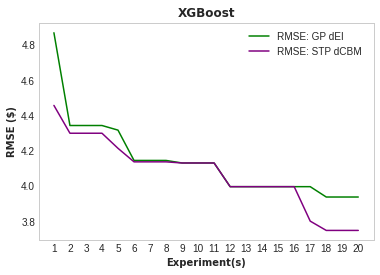

In [80]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(min_rmse_loser, color = 'Green', label='RMSE: GP dEI ')
plt.plot(min_rmse_winner, color = 'Purple', label='RMSE: STP dCBM ')

plt.title(title, weight = 'bold', family = 'Arial')
plt.xlabel('Experiment(s)', weight = 'bold', family = 'Arial') # x-axis label
plt.ylabel('RMSE ($)', weight = 'bold', family = 'Arial') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(min_rmse_loser)
plt.xticks(np.arange(count), np.arange(1, count + 1))
plt.grid(b=None)
plt.show() #visualize!


In [81]:
time_lose, time_win

(1538.0843329429626, 1140.1623332500458)